In [1]:
!pip install darts

In [2]:
!pip install seaborn

In [3]:
import torch
print(torch.__version__)  # Debería mostrar una versión como 2.2.0+cu117
print(torch.cuda.is_available())

2.4.0
False


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt


from tqdm import tqdm

import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from darts import TimeSeries
from darts.models import NBEATSModel,LightGBMModel,TFTModel
from darts.models.filtering.moving_average_filter import MovingAverageFilter

from darts.dataprocessing.transformers import MissingValuesFiller, StaticCovariatesTransformer, Scaler, InvertibleMapper
from darts.metrics import mape
from darts.dataprocessing.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

C:\Users\Ruben\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
pd.set_option('display.max_rows', None)

In [7]:
#Cargamos todos los datos que nos proporciona la competición
train = pd.read_csv('train.csv',parse_dates=["date"])
train_simple = pd.read_csv('train.csv',parse_dates=["date"])
test = pd.read_csv('test.csv',parse_dates=["date"])
transactions = pd.read_csv('transactions.csv',parse_dates=["date"])
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv',parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
events = pd.read_csv('holidays_events.csv',parse_dates=["date"])

In [8]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [9]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
#Extraemos información importante sobre el dataset como fechas de entrenamiento de inicio y final, de los test, numeros de familias, tiendas ... etc.
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_family_store = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

In [11]:
print(f"Number of families: {num_family}")
print(f"Number of stores: {num_store}")
print(f"Number of family-store combinations: {num_family_store}")
print("-------------------")
print(f"Number of unique train dates: {num_train_date}")
print(  f"Train date range            : {train_len} days from {train_start} to {train_end}")
print(f"Test date range             : {test_len} days from {test_start} to {test_end}")

Number of families: 33
Number of stores: 54
Number of family-store combinations: 1782
-------------------
Number of unique train dates: 1684
Train date range            : 1688 days from 2013-01-01 to 2017-08-15
Test date range             : 16 days from 2017-08-16 to 2017-08-31


In [12]:
#Tenemos 33 familias, 54 tiendas y 1782 combinaciones por día
#1688 dias de entrenamientos y 16 días a predecir

In [13]:
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [14]:
#Podemos observar que las fechas que faltan son los días de navidad y puede ser causa de que las tiendas esten cerradas por vacaciones.
print(f"Missing dates: {missing_dates}")

Missing dates: ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


In [15]:
#Indexamos el dataset por tienda, familia y fechas que son las cualidades que juntas lo hacen únicos
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
#train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)
train.id = train.id.interpolate(method="linear")


In [16]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [17]:
#Vamos a preprocessar la información del dataset del precio del petroleo oil
missing_oil_dates = pd.date_range(train_start, test_end).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_weekend_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

In [18]:
#Faltan estas fechas porque los fin de semana la bolsa de valores esta cerrada por tanto no hay información en estos días.
print(f"Number missing dates: {num_missing_oil_dates}")
print(f"Number Weekends: {num_weekend_missing}")

Number missing dates: 486
Number Weekends: 486


In [19]:
#Mergeamos el dataset oil para que tengas los valores de todas las fechas incluidas los fin de semana.
#También completamos los valores de los fin de semanas con una interpolación hacia ambos lados.
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)
oil.oil = oil.oil.interpolate(method="linear", limit_direction="both")

In [20]:
oil.head()

,date,oil
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [21]:
num_zero_sales = (train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
supposed_num_records = num_store * train_len
actual_records = len(transactions.index)
missing_records = supposed_num_records - actual_records - num_zero_sales

In [22]:
print(f"Num Zero sales: {num_zero_sales}")
print(f"Supposed number of records: {supposed_num_records}")
print(f"Actual number of records: {actual_records}")
print(f"Number of missing record: {missing_records}")

Num Zero sales: 7330
Supposed number of records: 91152
Actual number of records: 83488
Number of missing record: 334


In [23]:
#Como vemos falta información en el dataset de transactions porque no recoje información de los días que no ha habido ventas.
#Vamos a completar el dataset de train con la información correspondiente de los días faltantes
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
transactions = transactions.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)
transactions.loc[transactions.sales.eq(0), "transactions"] = 0.
transactions = transactions.drop(columns=["sales"])
transactions.transactions = transactions.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

In [24]:
#Dividimos los eventos en Nacionales, Regionales y Locales
national_events_name = sorted(events[events.locale.eq("National")].description.unique().tolist())
regional_events_name = sorted(events[events.locale.eq("Regional")].description.unique().tolist())
local_events_name = sorted(events[events.locale.eq("Local")].description.unique().tolist())

In [25]:
print(national_events_name)
print("#####################################################")
print(regional_events_name)
print("#####################################################")
print(local_events_name)

['Batalla de Pichincha', 'Black Friday', 'Carnaval', 'Cyber Monday', 'Dia de Difuntos', 'Dia de la Madre', 'Dia de la Madre-1', 'Dia del Trabajo', 'Inauguracion Mundial de futbol Brasil', 'Independencia de Cuenca', 'Independencia de Guayaquil', 'Mundial de futbol Brasil: Cuartos de Final', 'Mundial de futbol Brasil: Ecuador-Francia', 'Mundial de futbol Brasil: Ecuador-Honduras', 'Mundial de futbol Brasil: Ecuador-Suiza', 'Mundial de futbol Brasil: Final', 'Mundial de futbol Brasil: Octavos de Final', 'Mundial de futbol Brasil: Semifinales', 'Mundial de futbol Brasil: Tercer y cuarto lugar', 'Navidad', 'Navidad+1', 'Navidad-1', 'Navidad-2', 'Navidad-3', 'Navidad-4', 'Primer Grito de Independencia', 'Primer dia del ano', 'Primer dia del ano-1', 'Puente Dia de Difuntos', 'Puente Navidad', 'Puente Primer dia del ano', 'Recupero Puente Dia de Difuntos', 'Recupero Puente Navidad', 'Recupero Puente Primer dia del ano', 'Recupero puente Navidad', 'Recupero puente primer dia del ano', 'Terremot

In [26]:
#Como vemos hay muchas vacaciones y eventos que tienen nombre similares, por ello simplicaremos los nombres para que el dataset sea mas simple

events.loc[events['description'].str.contains('Navidad', case=False), 'description'] = 'Navidad'
events.loc[events['description'].str.contains('futbol', case=False), 'description'] = 'futbol'
events.loc[events['description'].str.contains('Terremoto Manabi', case=False), 'description'] = 'Terremoto Manabi'

In [27]:
#Ahora vamos a preprocesar las vacaciones que han sido transferidas y añadirles un prefijo

# remove transferred holidays
events = events[events.transferred.eq(False)]

#########################################
### Saturdays designated as work days ###
#########################################
work_days = events[events.type.eq("Work Day")]
print(work_days)
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)

work_days.work_day = work_days.work_day.notna().astype(int)

# remove work days after extracting above
events = events[events.type!="Work Day"].reset_index(drop=True)

###################################
### local holidays (city level) ###
###################################
local_holidays = events[events.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### regional holidays (state level) ###
#######################################
regional_holidays = events[events.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### national holidays ###
#########################
national_holidays = events[events.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

events.head()

          date      type    locale locale_name  \
42  2013-01-05  Work Day  National     Ecuador   
43  2013-01-12  Work Day  National     Ecuador   
149 2014-12-20  Work Day  National     Ecuador   
161 2015-01-10  Work Day  National     Ecuador   
283 2016-11-12  Work Day  National     Ecuador   

                            description  transferred  
42                              Navidad        False  
43   Recupero puente primer dia del ano        False  
149                             Navidad        False  
161  Recupero Puente Primer dia del ano        False  
283     Recupero Puente Dia de Difuntos        False  


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [28]:
events["type"].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Event'],
      dtype=object)

# Data Exploration

In [29]:
data_explorer = pd.concat(
    [train ], axis=0, ignore_index=True,
).merge(
    oil, on="date", how="left",
).merge(
    stores, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    events, on="date", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

# fill columns with 0s to indicate absence of holidays/events


# include date-related future covariates
data_explorer["day"] = data_explorer.date.dt.day
data_explorer["month"] = data_explorer.date.dt.month
data_explorer["year"] = data_explorer.date.dt.year
data_explorer["day_of_week"] = data_explorer.date.dt.dayofweek
data_explorer["day_of_year"] = data_explorer.date.dt.dayofyear
data_explorer["week_of_year"] = data_explorer.date.dt.isocalendar().week.astype(int)
data_explorer["date_index"] = data_explorer.date.factorize()[0] # sort by date above before computing this

In [30]:
work_days.head()

,date,work_day
0,2013-01-05,1
1,2013-01-12,1
2,2014-12-20,1
3,2015-01-10,1
4,2016-11-12,1


In [31]:
data_explorer.head()

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_x,cluster,work_day,type_y,locale,locale_name,description,transferred,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0


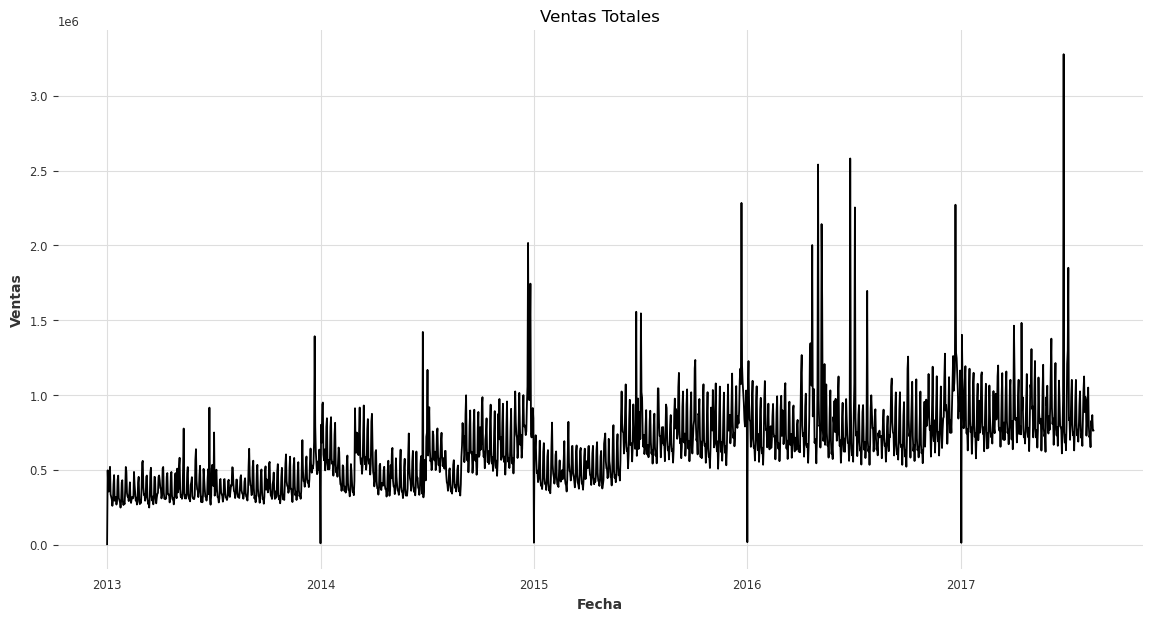

In [32]:
#Vamos a ver las ventas totales por día, y vemos que tiene un caracter creciente.
#Podemos observar 2 días al año donde no se producen ventas o casi no se producen que coinciden con el dia de navidad.
plt.figure(figsize=(14, 7))
plt.plot(data_explorer.groupby('date').sum()['sales'])
plt.title('Ventas Totales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

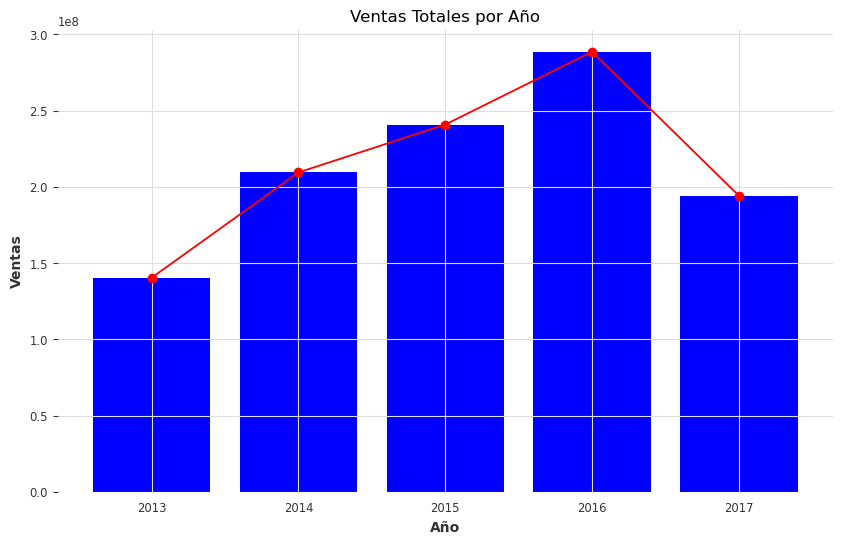

In [33]:
#Anualmente también es creciente pero como el dataset de train termina en agosto, por eso en 2017 hay menos ventas
sales_by_year = train.groupby(pd.to_datetime(train['date']).dt.year)['sales'].sum().reset_index()
sales_by_year.rename(columns={'date': 'year'}, inplace=True)
plt.figure(figsize=(10,6))
plt.plot(sales_by_year['year'],sales_by_year['sales'], marker='o', linestyle='-', color='r')
plt.bar(sales_by_year['year'], sales_by_year['sales'], color='b')
plt.title('Ventas Totales por Año')
plt.xlabel('Año')
plt.ylabel('Ventas')
plt.grid(True)
plt.show() 

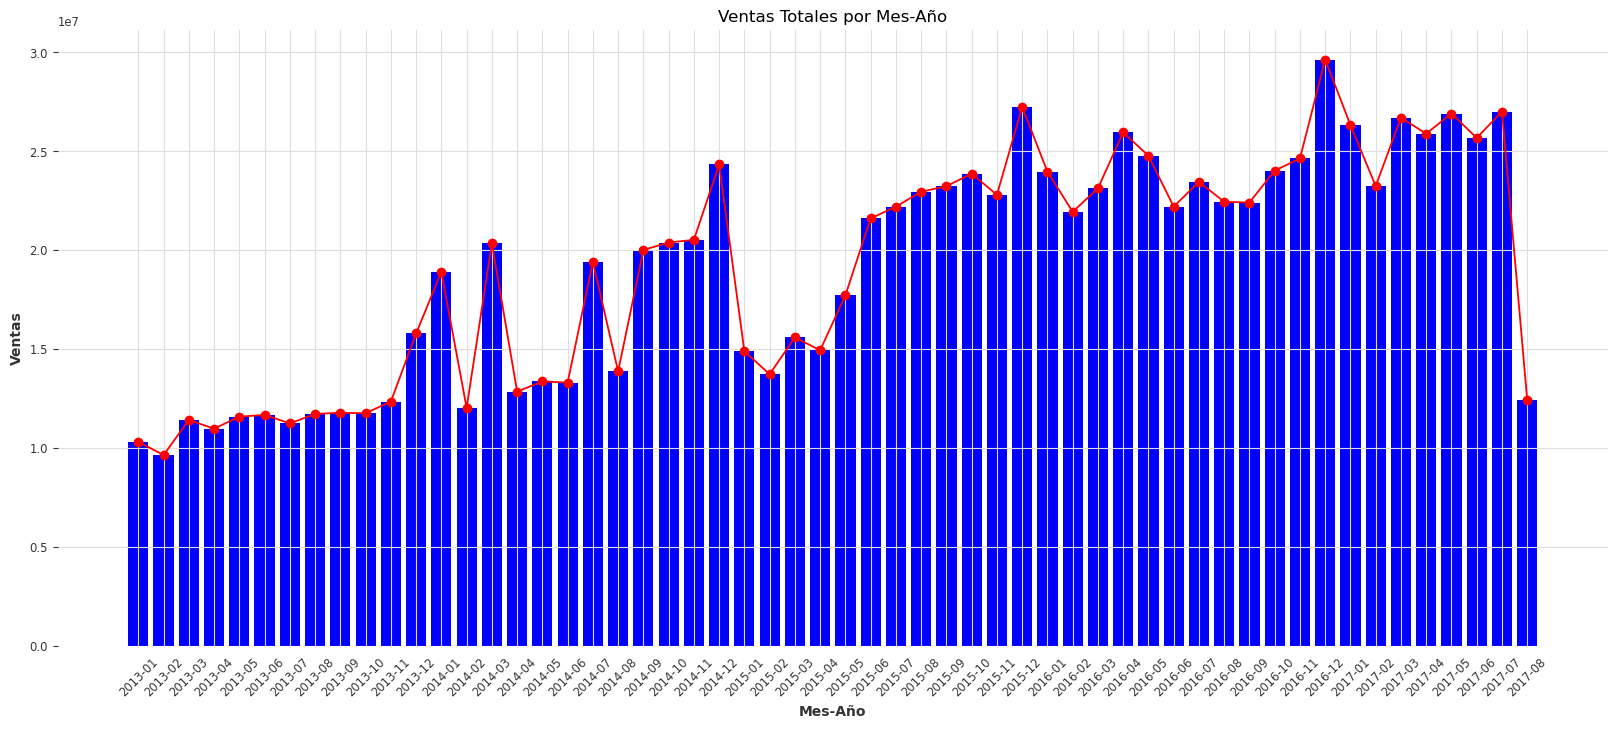

In [34]:
#Vemos que los el mes de Diciembre suele ser el mes en el que más ventas hay
sales_by_year_month = train.groupby(pd.to_datetime(train['date']).dt.to_period('M').astype(str))['sales'].sum().reset_index()
sales_by_year_month.rename(columns={'date': 'month-year'}, inplace=True)
plt.figure(figsize=(20,8))
plt.plot(sales_by_year_month['month-year'],sales_by_year_month['sales'], marker='o', linestyle='-', color='r')
plt.bar(sales_by_year_month['month-year'], sales_by_year_month['sales'], color='b')
plt.xticks(rotation=45)
plt.title('Ventas Totales por Mes-Año')
plt.xlabel('Mes-Año')
plt.ylabel('Ventas')
plt.grid(True)
plt.show() 

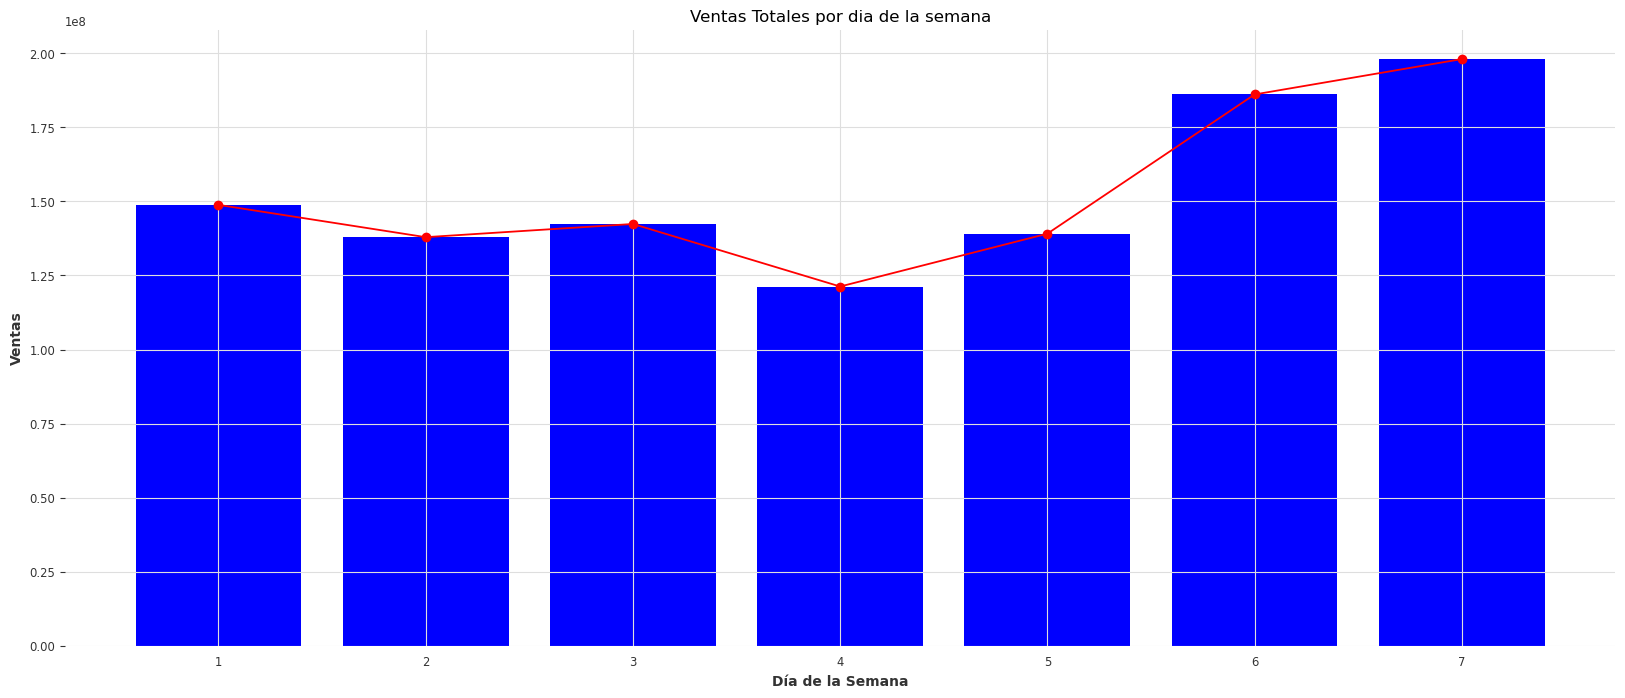

In [35]:
#Vemos que por lo general el día de la semana que vemos se vende es el jueves y los que más sabado y domingo
sales_by_day_week = train.groupby(pd.to_datetime(train['date']).dt.dayofweek + 1)['sales'].sum().reset_index()
sales_by_day_week.rename(columns={'date': 'day_of_week'}, inplace=True)

plt.figure(figsize=(20,8))
plt.plot(sales_by_day_week['day_of_week'],sales_by_day_week['sales'], marker='o', linestyle='-', color='r')
plt.bar(sales_by_day_week['day_of_week'], sales_by_day_week['sales'], color='b')
plt.title('Ventas Totales por dia de la semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Ventas')
plt.grid(True)
plt.show() 

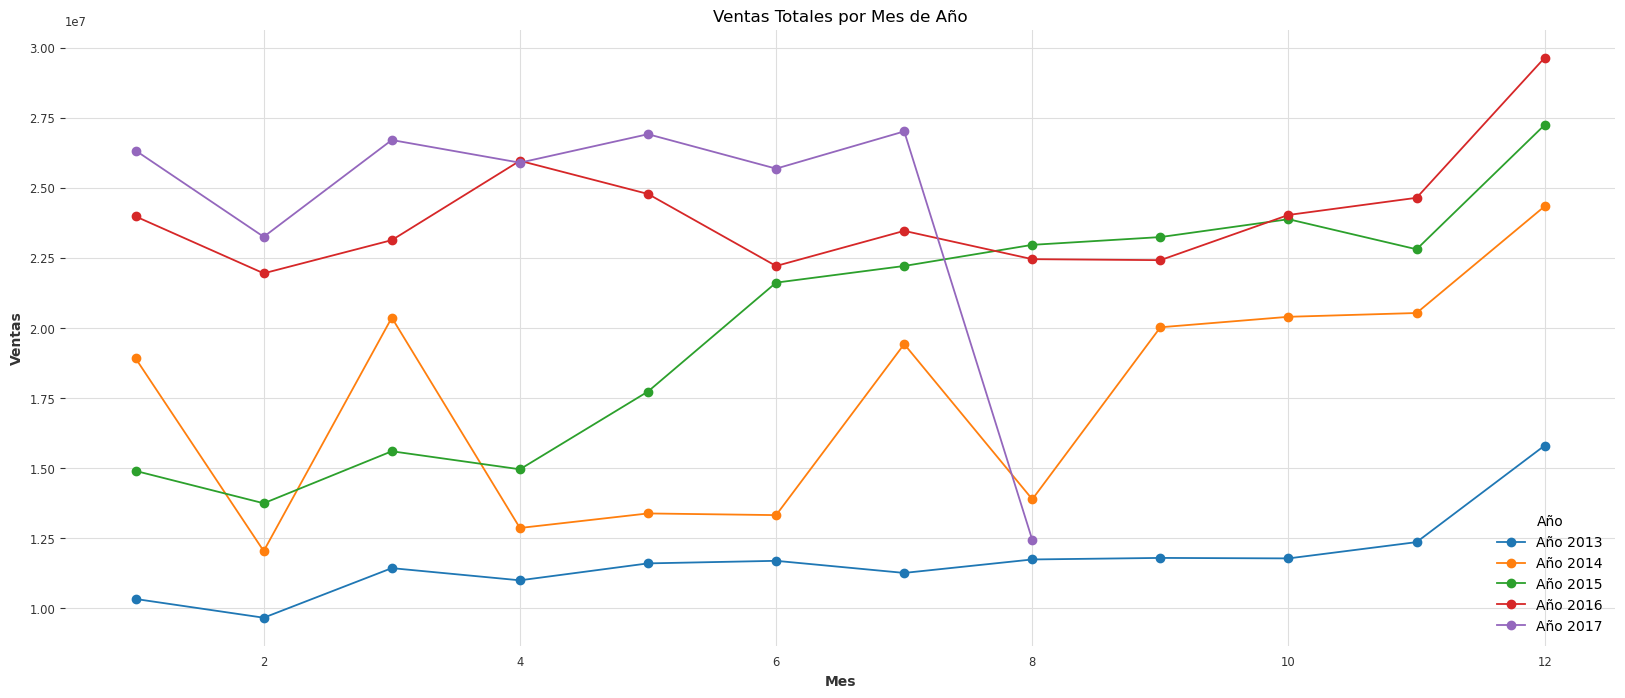

In [36]:
sales_by_year_month = train.assign(
    year=pd.to_datetime(train['date']).dt.year,
    month=pd.to_datetime(train['date']).dt.month
)

sales_by_year_month = sales_by_year_month.groupby(['year', 'month'])['sales'].sum().reset_index()

# Crear el gráfico de líneas
plt.figure(figsize=(20, 8))

# Colores para cada año
colors = plt.cm.tab10(range(len(sales_by_year_month['year'].unique())))

# Trazar cada año por separado
for i, year in enumerate(sales_by_year_month['year'].unique()):
    data_for_year = sales_by_year_month[sales_by_year_month['year'] == year]
    plt.plot(data_for_year['month'], data_for_year['sales'], marker='o', linestyle='-', color=colors[i], label=f'Año {year}')

plt.title('Ventas Totales por Mes de Año')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.legend(title='Año')
plt.grid(True)
plt.show()
#Esta gráfica que las ventas tienen tendencia a aumentar a lo largo que pasa el año
#También podemos ver que el último año (2017) iba teniendo un resultados mayores a los años anteriores, pero por la falta de información del resto
#del año decae, pero por la tendencia podemos especular que 2017 acabará con mayores ventas que los años anteriores

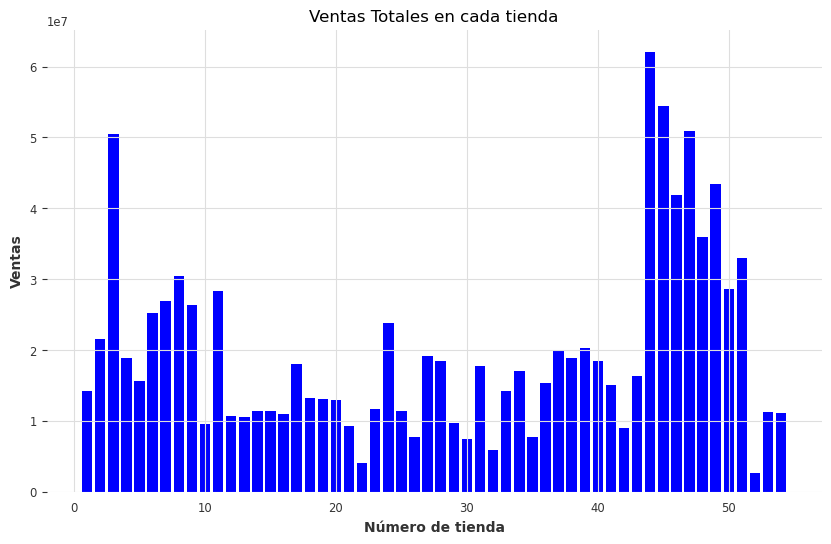

In [37]:
sales_by_store = train.groupby('store_nbr')['sales'].sum().reset_index()
plt.figure(figsize=(10,6))
plt.bar(sales_by_store['store_nbr'], sales_by_store['sales'], color='b')
plt.title('Ventas Totales en cada tienda')
plt.xlabel('Número de tienda')
plt.ylabel('Ventas')

plt.grid(True)
plt.show()

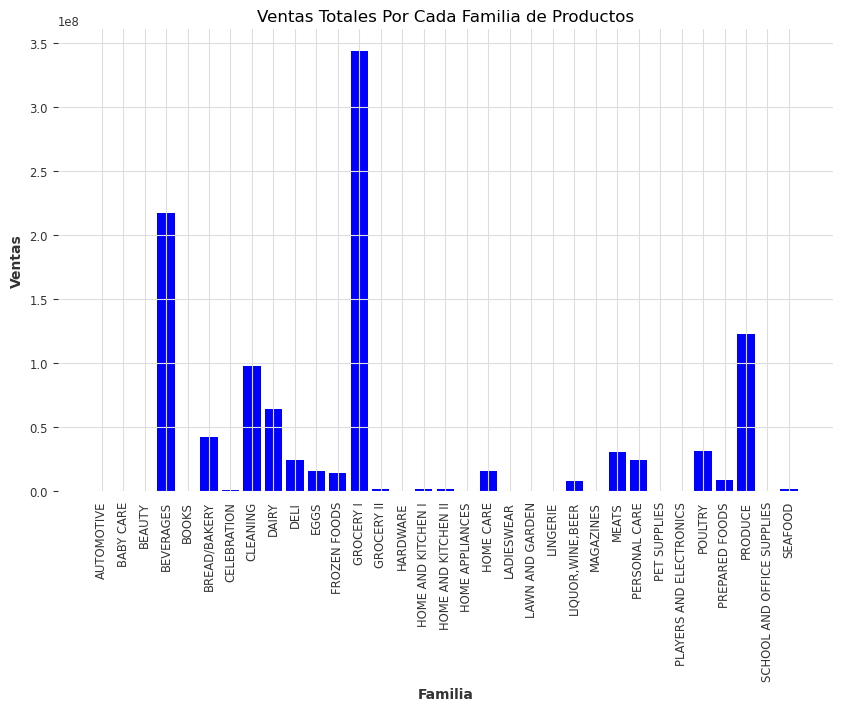

In [38]:
sales_by_family = train.groupby('family')['sales'].sum().reset_index()
plt.figure(figsize=(10,6))
plt.bar(sales_by_family['family'], sales_by_family['sales'], color='b')
plt.xticks(rotation=90)
plt.title('Ventas Totales Por Cada Familia de Productos')
plt.xlabel('Familia')
plt.ylabel('Ventas')

plt.grid(True)
plt.show()
#Observamos que la mayoría de las ventas son producidad por unas cuantas familias de productos

In [39]:
data_explorer.head()

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_x,cluster,work_day,type_y,locale,locale_name,description,transferred,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0


In [40]:
#Agrupamos las ventas por las fechas y el precio del petroleo para ver la correlación que tiene
mean_sales_per_day = data_explorer.groupby('date')['sales'].mean().reset_index()['sales']
oil_per_day = data_explorer.groupby('date')['oil'].first().reset_index()['oil']

<Axes: xlabel='oil', ylabel='sales'>

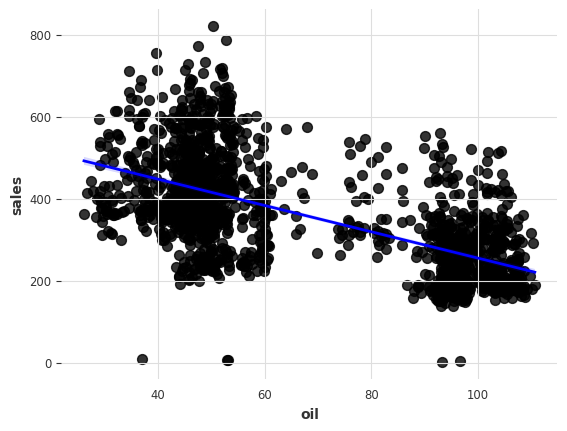

In [41]:
#Vemos que tiene una correlación negativa a mayor el precio de petroleo menos ventas se producen
sns.regplot(x=oil_per_day, y=mean_sales_per_day, scatter_kws={'s':50}, line_kws={'color':'blue'})

<Axes: xlabel='onpromotion', ylabel='sales'>

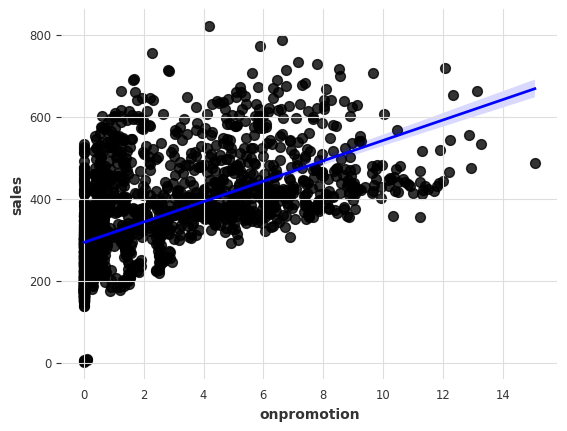

In [42]:
#Ahora vemos que tiene correlacion positiva con el numero de productos que este en promocion
onpromotion_per_day = data_explorer.groupby('date')['onpromotion'].mean().reset_index()['onpromotion']
sns.regplot(x=onpromotion_per_day, y=mean_sales_per_day, scatter_kws={'s':50}, line_kws={'color':'blue'})

In [43]:
data_explorer['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

Text(0, 0.5, 'Number of Unique Stores')

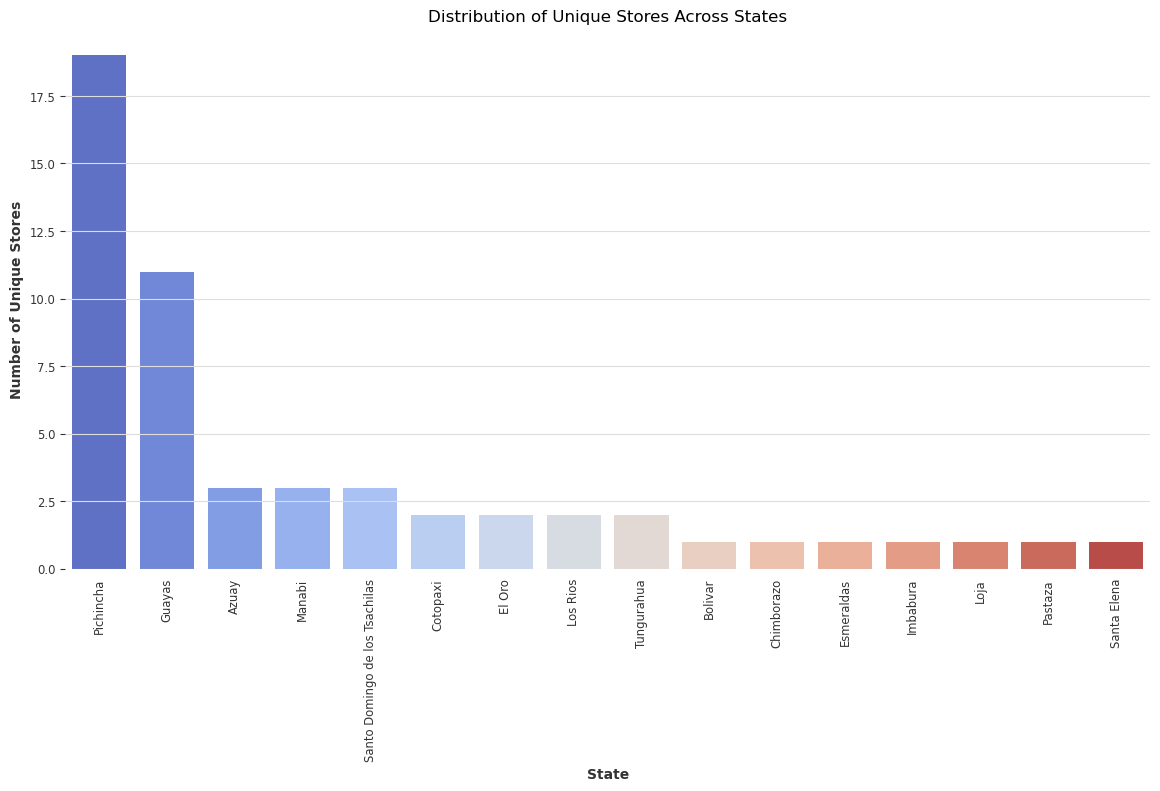

In [44]:
#Ahora vemos la cantidad de tiendas que pertenecen a cada estado, y vemos que la mayor parte de las tiendas esta dividida en 2 estados
unique_stores = data_explorer[['state', 'store_nbr']].drop_duplicates()
store_counts = unique_stores.groupby('state')['store_nbr'].count().reset_index()
store_counts = store_counts.rename(columns={'store_nbr': 'number_of_stores'})
store_counts = store_counts.sort_values(by='number_of_stores', ascending=False)
# Configurar el tamaño de la figura
plt.figure(figsize=(14, 7))

# Crear el gráfico de barras
sns.barplot(x='state', y='number_of_stores', data=store_counts, palette='coolwarm')

plt.xticks(rotation=90)
# Añadir títulos y etiquetas
plt.title('Distribution of Unique Stores Across States')
plt.xlabel('State')
plt.ylabel('Number of Unique Stores')


In [45]:
data_explorer.head()

,id,date,store_nbr,family,sales,onpromotion,oil,city,state,type_x,cluster,work_day,type_y,locale,locale_name,description,transferred,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,1,1,0


In [46]:
data_explorer["description"].unique()

array(['Primer dia del ano', nan, 'Carnaval', 'Fundacion de Manta',
       'Provincializacion de Cotopaxi', 'Fundacion de Cuenca',
       'Cantonizacion de Libertad', 'Cantonizacion de Riobamba',
       'Viernes Santo', 'Dia del Trabajo', 'Dia de la Madre-1',
       'Cantonizacion del Puyo', 'Dia de la Madre',
       'Batalla de Pichincha', 'Cantonizacion de Guaranda',
       'Provincializacion de Imbabura', 'Fundacion de Machala',
       'Cantonizacion de Latacunga', 'Cantonizacion de El Carmen',
       'Fundacion de Santo Domingo', 'Cantonizacion de Cayambe',
       'Fundacion de Guayaquil-1', 'Fundacion de Guayaquil',
       'Fundacion de Esmeraldas', 'Primer Grito de Independencia',
       'Fundacion de Riobamba', 'Fundacion de Ambato',
       'Fundacion de Ibarra', 'Cantonizacion de Quevedo',
       'Traslado Independencia de Guayaquil', 'Dia de Difuntos',
       'Independencia de Cuenca', 'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena', 'Independencia

In [47]:
#Ahora vamos a calcular el impacto que tienen sobre sales las distintas festividades


# Agrupar por fecha y calcular la media de ventas diarias
daily_sales = data_explorer.groupby('date')['sales'].mean().reset_index()
# Unir la columna 'description' al DataFrame, asegurando que cada día tenga la festividad correcta
daily_sales = pd.merge(daily_sales, data_explorer[['date', 'description']].drop_duplicates(), on='date', how='left')
daily_sales = daily_sales.rename(columns={'sales': 'average_sales'})
daily_sales.head()

,date,average_sales,description
0,2013-01-01,1.409438,Primer dia del ano
1,2013-01-02,278.390807,NaN
2,2013-01-03,202.840197,NaN
3,2013-01-04,198.911154,NaN
4,2013-01-05,267.873244,NaN


In [48]:
# Calcular la media de ventas en días normales (sin festividad)
average_sales_normal_days = daily_sales[daily_sales['description'].isna()]['average_sales'].mean()
# Filtrar los días con festividad (donde description no es NaN)
festive_days = daily_sales[~daily_sales['description'].isna()]

# Calcular la media de ventas por festividad y el impacto respecto a días normales
mean_sales_by_festivity = festive_days.groupby('description')['average_sales'].mean().reset_index()

# Calcular el impacto en ventas comparado con los días normales
mean_sales_by_festivity['impact_on_sales'] = mean_sales_by_festivity['average_sales'] - average_sales_normal_days
# Ordenar por impacto en ventas (positivo o negativo)
mean_sales_by_festivity = mean_sales_by_festivity.sort_values(by='impact_on_sales', ascending=False)

In [49]:
mean_sales_by_festivity.tail()

,description,average_sales,impact_on_sales
0,Batalla de Pichincha,309.219029,-42.639103
51,Viernes Santo,292.693438,-59.164695
10,Cantonizacion del Puyo,292.534443,-59.323689
6,Cantonizacion de Libertad,286.318917,-65.539215
37,Primer dia del ano,5.656663,-346.201469


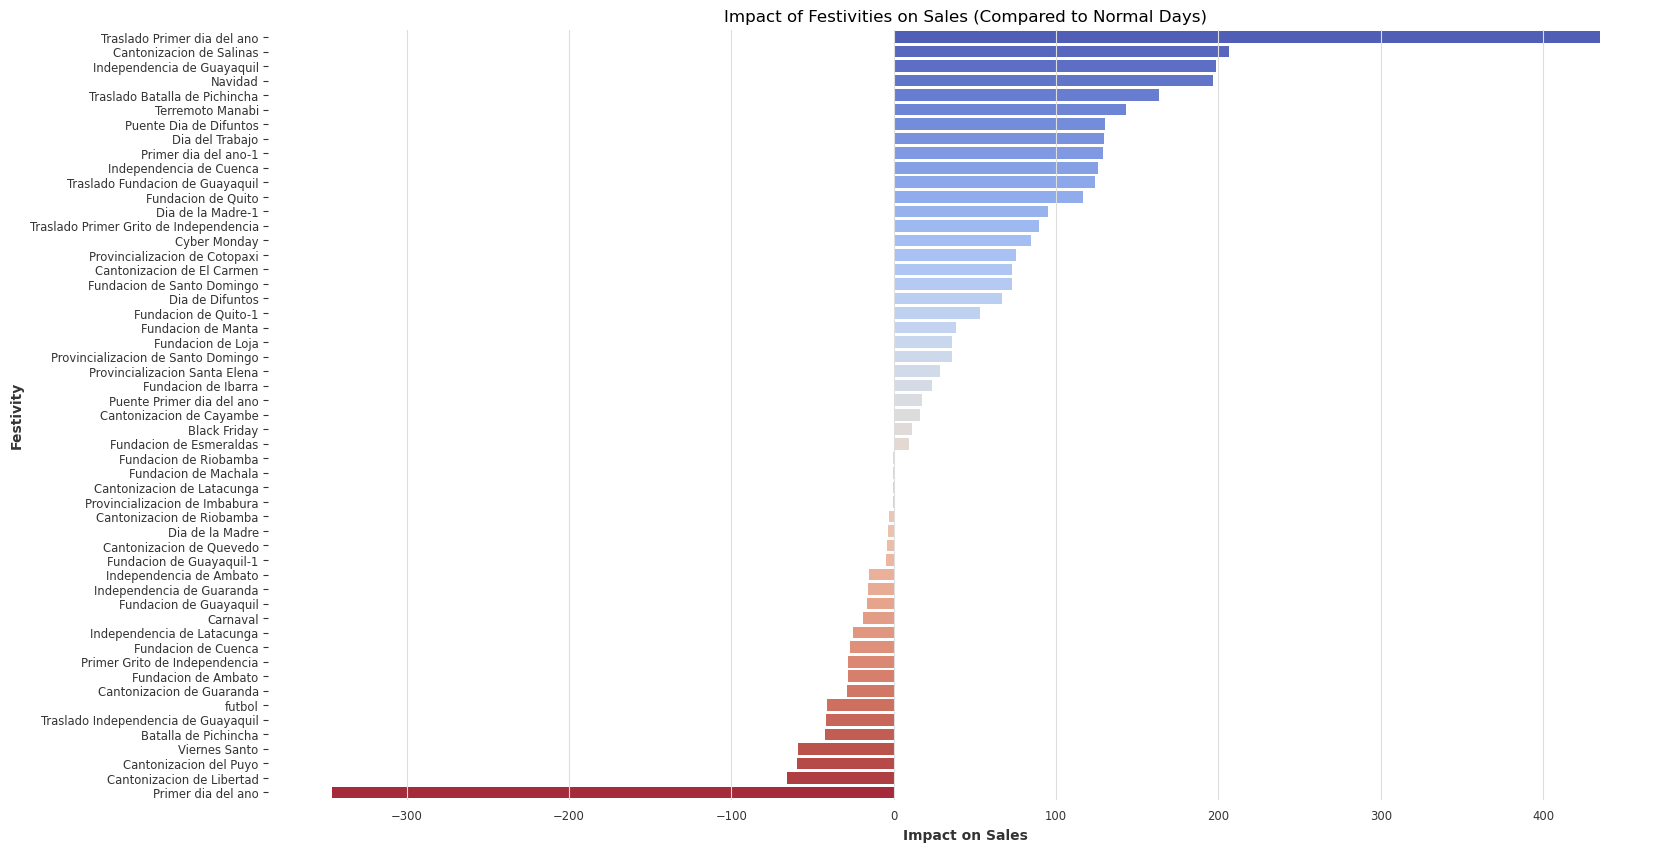

In [50]:
plt.figure(figsize=(18, 10))

# Crear el gráfico de barras
sns.barplot(x='impact_on_sales', y='description', data=mean_sales_by_festivity, palette='coolwarm')

# Añadir títulos y etiquetas
plt.title('Impact of Festivities on Sales (Compared to Normal Days)')
plt.xlabel('Impact on Sales')
plt.ylabel('Festivity')

# Mostrar la gráfica
plt.show()

In [51]:
# Calcular el valor absoluto del impacto en ventas
mean_sales_by_festivity['abs_impact_on_sales'] = mean_sales_by_festivity['impact_on_sales'].abs()
# Ordenar por el impacto absoluto en ventas
mean_sales_by_festivity_sorted = mean_sales_by_festivity.sort_values(by='abs_impact_on_sales', ascending=False)
# Extraer los nombres de las 10 festividades con mayor impacto en valor absoluto
top_15_festivities = mean_sales_by_festivity_sorted['description'].head(15).tolist()


In [52]:
top_15_festivities

['Traslado Primer dia del ano',
 'Primer dia del ano',
 'Cantonizacion de Salinas',
 'Independencia de Guayaquil',
 'Navidad',
 'Traslado Batalla de Pichincha',
 'Terremoto Manabi',
 'Puente Dia de Difuntos',
 'Dia del Trabajo',
 'Primer dia del ano-1',
 'Independencia de Cuenca',
 'Traslado Fundacion de Guayaquil',
 'Fundacion de Quito',
 'Dia de la Madre-1',
 'Traslado Primer Grito de Independencia']

In [53]:
national_holidays.columns

Index(['date', 'nat_Batalla de Pichincha', 'nat_Black Friday', 'nat_Carnaval',
       'nat_Cyber Monday', 'nat_Dia de Difuntos', 'nat_Dia de la Madre',
       'nat_Dia de la Madre-1', 'nat_Dia del Trabajo',
       'nat_Independencia de Cuenca', 'nat_Independencia de Guayaquil',
       'nat_Navidad', 'nat_Primer Grito de Independencia',
       'nat_Primer dia del ano', 'nat_Primer dia del ano-1',
       'nat_Puente Dia de Difuntos', 'nat_Puente Primer dia del ano',
       'nat_Terremoto Manabi', 'nat_Traslado Batalla de Pichincha',
       'nat_Traslado Independencia de Guayaquil',
       'nat_Traslado Primer Grito de Independencia',
       'nat_Traslado Primer dia del ano', 'nat_Viernes Santo', 'nat_futbol'],
      dtype='object')

## Training Preparation


In [54]:
#Vamos a crear las TimeSeries necesarias para entrenar nuesto modelo de Darts
#Necesitamos la Target Series, future covariates y past covariates
# De paso también añadiremos medias moviles para incluir mas información 
train = pd.merge(train, stores, on ='store_nbr')
train = train.sort_values(["store_nbr","family","date"])
test = test.sort_values(["store_nbr","family","date"])
train = train.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
33,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13
66,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
99,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
132,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13


In [55]:
#Cogemos el dataframe de test para posteriormente utilizarlo para la submission y ordenamos por tienda y familia de productos
test_submit = test.drop(['onpromotion'],axis=1)
test_submit = test.sort_values(by=["store_nbr",'family'])
test_submit.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1782,3002670,2017-08-17,1,AUTOMOTIVE,0
3564,3004452,2017-08-18,1,AUTOMOTIVE,0
5346,3006234,2017-08-19,1,AUTOMOTIVE,0
7128,3008016,2017-08-20,1,AUTOMOTIVE,0


In [56]:
#Creamos el timserie target que contiene la información de sales
families = train["family"].unique()
sales_fam_ts = {}
for fam in families:
    family_df = train.loc[train['family'] == fam]
    family_ts = TimeSeries.from_group_dataframe(family_df,
                                                time_col='date',
                                                group_cols=['store_nbr','family'],
                                                static_cols=['city','state','type','cluster'],
                                                value_cols='sales',
                                                fill_missing_dates=True,
                                                freq='D'
                                               )
    for ts in family_ts:
        ts = ts.astype(np.float32)
    family_ts = sorted(family_ts, key=lambda ts: int(ts.static_covariates_values()[0,0]))
    sales_fam_ts[fam] = family_ts

In [57]:
prueba = sales_fam_ts['AUTOMOTIVE'][0].pd_dataframe()
prueba.head()

component,sales
date,
2013-01-01,0.0
2013-01-02,2.0
2013-01-03,3.0
2013-01-04,3.0
2013-01-05,5.0


In [58]:
# Ahora vamos a procesar las covariables que necesitamos para entrenar nuesto modelo
# Primero necesitamos una timeserie que tenga las fechas necesarios con información sacada a partir de estas
full_time_range = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')


year = datetime_attribute_timeseries(time_index = full_time_range, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_range, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_range, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_range, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_range, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_range, attribute="weekofyear")
month_start = datetime_attribute_timeseries(time_index = full_time_range, attribute="is_month_start")
month_end = datetime_attribute_timeseries(time_index = full_time_range, attribute="is_month_end")

timesteps = TimeSeries.from_times_and_values(times=full_time_range,
                                             values=np.arange(len(full_time_range)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps).stack(month_start).stack(month_end)
time_cov = time_cov.astype(np.float32)

In [59]:
display(print(time_cov.components.values))

['year' 'month' 'day' 'dayofyear' 'dayofweek' 'weekofyear'
 'linear_increase' 'is_month_start' 'is_month_end']


None

In [60]:
#Convertimos los datos de oil en una TimeSeries y calcualar sus media móviles
oil = TimeSeries.from_dataframe(oil, 
                                time_col = 'date', 
                                value_cols = ['oil'],
                                freq = 'D')

oil = oil.astype(np.float32)
oil_moving_average_7 = MovingAverageFilter(window=7)
oil_moving_average_14 = MovingAverageFilter(window=14)
oil_moving_average_28 = MovingAverageFilter(window=28)
ma_7 = oil_moving_average_7.filter(oil).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_14 = oil_moving_average_14.filter(oil).astype(np.float32)
ma_14 = ma_14.with_columns_renamed(col_names=ma_14.components, col_names_new="oil_ma_14")
ma_28 = oil_moving_average_28.filter(oil).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil = oil.stack(ma_7).stack(ma_14).stack(ma_28)

In [61]:
prueba = oil.pd_dataframe()
prueba.head()

component,oil,oil_ma_7,oil_ma_14,oil_ma_28
date,,,,
2013-01-01,93.139999,93.092499,93.127144,93.409286
2013-01-02,93.139999,93.103333,93.137497,93.399330
2013-01-03,92.970001,93.114998,93.131111,93.454376
2013-01-04,93.120003,93.127144,93.198997,93.574120
2013-01-05,93.146667,93.137146,93.235451,93.687225


In [62]:
top_15_festivities

['Traslado Primer dia del ano',
 'Primer dia del ano',
 'Cantonizacion de Salinas',
 'Independencia de Guayaquil',
 'Navidad',
 'Traslado Batalla de Pichincha',
 'Terremoto Manabi',
 'Puente Dia de Difuntos',
 'Dia del Trabajo',
 'Primer dia del ano-1',
 'Independencia de Cuenca',
 'Traslado Fundacion de Guayaquil',
 'Fundacion de Quito',
 'Dia de la Madre-1',
 'Traslado Primer Grito de Independencia']

In [63]:
# Ahora vamos a crear una listas de dataframes con la información de las vacaciones que corresponden a cada tienda
stores_num = len(stores["store_nbr"].unique())
events_store = []
for i in range(0,stores_num):
    holidays_store_df =  pd.DataFrame(columns=['date'])
    holidays_store_df["date"] = events["date"]
    holidays_store_df["national_holiday"] = np.where(((events["type"] == "Holiday") & (events["locale"] == "National")), 1, 0)

    holidays_store_df["earthquake_relief"] = np.where(events['description'].str.contains('Terremoto Manabi'), 1, 0)

    holidays_store_df["christmas"] = np.where(events['description'].str.contains('Navidad'), 1, 0)

    holidays_store_df["first_day_year"] = np.where(events['description'].str.contains('Primer dia'), 1, 0)

    holidays_store_df["Salinas"] = np.where(events['description'].str.contains('Cantonizacion de Salinas'), 1, 0)

    holidays_store_df["Pichincha"] = np.where(events['description'].str.contains('Batalla de Pichincha'), 1, 0)

    holidays_store_df["Guayaquil"] = np.where(events['description'].str.contains('Independencia de Guayaquil'), 1, 0)

    holidays_store_df["mothers_day"] = np.where(events['description'].str.contains('Dia de la Madre'), 1, 0)


    holidays_store_df["football_event"] = np.where(events['description'].str.contains('futbol'), 1, 0)

    holidays_store_df["national_event"] = np.where(((events["type"] == "Event") & (events["locale"] == "National") & (~events['description'].str.contains('Terremoto Manabi')) & (~events['description'].str.contains('futbol'))), 1, 0)

    holidays_store_df["work_day"] = np.where((events["type"] == "Work Day"), 1, 0)

    holidays_store_df["local_holiday"] = np.where(((events["type"] == "Holiday") & ((events["locale_name"] == stores['state'][i]) | (events["locale_name"] == stores['city'][i]))), 1, 0)
    
    events_store.append(holidays_store_df)


In [64]:
#Convetimos los datafreames a timeSeries pero antes nos aseguramos de que no hata duplicado
stores_events_ts = []
for i in range(0,stores_num):
    holidays_store_df = events_store[i].set_index('date')

    holidays_store_df = holidays_store_df.loc[~(holidays_store_df==0).all(axis=1)]
    
    holidays_store_df = holidays_store_df.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max', 
                           'christmas':'max', 'football_event':'max', 
                           'national_event':'max', 'work_day':'max', 
                           'local_holiday':'max'}).reset_index()
    
    holidays_TS = TimeSeries.from_dataframe(holidays_store_df, 
                                        time_col = 'date',
                                        fill_missing_dates=True,
                                        fillna_value=0,
                                        freq='D')
            
    holidays_TS = holidays_TS.slice(pd.Timestamp('20130101'),pd.Timestamp('20170831'))
    holidays_TS = holidays_TS.astype(np.float32)
    stores_events_ts.append(holidays_TS)

    

In [65]:
prueba = stores_events_ts[0].pd_dataframe()
prueba.tail()

component,national_holiday,earthquake_relief,christmas,football_event,national_event,work_day,local_holiday
date,,,,,,,
2017-08-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:

promotions = pd.concat([train_simple,test],axis=0)
#promotions = promotions.sort_values(["store_nbr","family","date"])

promotions_family = {}
for fam in families:
    family_df = promotions.loc[promotions["family"] == fam]

    promo_fam_ts = TimeSeries.from_group_dataframe(family_df,
                                                   time_col="date",
                                                   group_cols=["store_nbr","family"],
                                                   value_cols="onpromotion",
                                                   fill_missing_dates=True,
                                                   freq="D")

    # Moving Averages for Promotion Family Dictionaries
    promo_moving_average_7 = MovingAverageFilter(window=7)
    promo_moving_average_14 = MovingAverageFilter(window=14)
    promo_moving_average_28 = MovingAverageFilter(window=28)

    promotion_moving_average = []
    for ts in promo_fam_ts:
        ts = ts.astype(np.float32)
        ma_7 = promo_moving_average_7.filter(ts)
        ma_7 = TimeSeries.from_series(ma_7.pd_series())  
        ma_7 = ma_7.astype(np.float32)
        ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
        ma_14 = promo_moving_average_14.filter(ts)
        ma_14 = TimeSeries.from_series(ma_14.pd_series())  
        ma_14 = ma_14.astype(np.float32)
        ma_14 = ma_14.with_columns_renamed(col_names=ma_14.components, col_names_new="promotion_ma_14")
        ma_28 = promo_moving_average_28.filter(ts)
        ma_28 = TimeSeries.from_series(ma_28.pd_series())  
        ma_28 = ma_28.astype(np.float32)
        ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
        ts = ts.stack(ma_7).stack(ma_14).stack(ma_28)
        promotion_moving_average.append(ts)

    promotions_family[fam] = promotion_moving_average
            

In [67]:
prueba = promotions_family["AUTOMOTIVE"][0].pd_dataframe()
prueba.head()

component,onpromotion,promotion_ma_7,promotion_ma_14,promotion_ma_28
date,,,,
2013-01-01,0.0,0.0,0.0,0.0
2013-01-02,0.0,0.0,0.0,0.0
2013-01-03,0.0,0.0,0.0,0.0
2013-01-04,0.0,0.0,0.0,0.0
2013-01-05,0.0,0.0,0.0,0.0


In [68]:
#Ahora vamos a agrupar todos los TimeSeries de las distintas covariables futuras en un mismo timeSeries
#Empezamos con la serie de fechas y de la información de precio del petroleo ya que hay una unica entrada por día
future_covariates = time_cov.stack(oil)

In [69]:
prueba = future_covariates.pd_dataframe()
prueba.head()

component,year,month,day,dayofyear,dayofweek,weekofyear,linear_increase,is_month_start,is_month_end,oil,oil_ma_7,oil_ma_14,oil_ma_28
time,,,,,,,,,,,,,
2013-01-01,2013.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,93.139999,93.092499,93.127144,93.409286
2013-01-02,2013.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,93.139999,93.103333,93.137497,93.399330
2013-01-03,2013.0,0.0,2.0,2.0,3.0,0.0,2.0,0.0,0.0,92.970001,93.114998,93.131111,93.454376
2013-01-04,2013.0,0.0,3.0,3.0,4.0,0.0,3.0,0.0,0.0,93.120003,93.127144,93.198997,93.574120
2013-01-05,2013.0,0.0,4.0,4.0,5.0,0.0,4.0,0.0,0.0,93.146667,93.137146,93.235451,93.687225


In [70]:
#Ahora agrupa las timeseries con la información de la vacaciones de las tiendas
future_store_covariates = []
for st in range(0,num_store):
    covariates = stores_events_ts[st].stack(future_covariates)
    future_store_covariates.append(covariates)

In [71]:
prueba = future_store_covariates[0].pd_dataframe()
prueba.head()

component,national_holiday,earthquake_relief,christmas,football_event,national_event,work_day,local_holiday,year,month,day,dayofyear,dayofweek,weekofyear,linear_increase,is_month_start,is_month_end,oil,oil_ma_7,oil_ma_14,oil_ma_28
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,93.139999,93.092499,93.127144,93.409286
2013-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,93.139999,93.103333,93.137497,93.399330
2013-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,2.0,2.0,3.0,0.0,2.0,0.0,0.0,92.970001,93.114998,93.131111,93.454376
2013-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,3.0,3.0,4.0,0.0,3.0,0.0,0.0,93.120003,93.127144,93.198997,93.574120
2013-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,4.0,4.0,5.0,0.0,4.0,0.0,0.0,93.146667,93.137146,93.235451,93.687225


In [72]:
#Ahora finalmente la agrupamos con la ultima, con las de las promociones
future_covariates_fam = {}
for fam in families:
    promotion_family = promotions_family[fam]
    covariates = [promotion_family[i].stack(future_store_covariates[i]) for i in range(0,len(promotion_family))]
    future_covariates_fam[fam] = covariates

In [73]:
prueba = future_covariates_fam["AUTOMOTIVE"][0].pd_dataframe()
prueba.head()

component,onpromotion,promotion_ma_7,promotion_ma_14,promotion_ma_28,national_holiday,earthquake_relief,christmas,football_event,national_event,work_day,local_holiday,year,month,day,dayofyear,dayofweek,weekofyear,linear_increase,is_month_start,is_month_end,oil,oil_ma_7,oil_ma_14,oil_ma_28
date,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,93.139999,93.092499,93.127144,93.409286
2013-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,93.139999,93.103333,93.137497,93.399330
2013-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,2.0,2.0,3.0,0.0,2.0,0.0,0.0,92.970001,93.114998,93.131111,93.454376
2013-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,3.0,3.0,4.0,0.0,3.0,0.0,0.0,93.120003,93.127144,93.198997,93.574120
2013-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,0.0,4.0,4.0,5.0,0.0,4.0,0.0,0.0,93.146667,93.137146,93.235451,93.687225


In [74]:
#Ahora vamos a crear las TimeSeries las las covariables pasadas, que en nuestro caso son las transacciones
transactions.sort_values(["store_nbr","date"],inplace=True)
transactions_ts = TimeSeries.from_group_dataframe(transactions,
                                                  time_col='date',
                                                  group_cols=['store_nbr'],
                                                  value_cols='transactions',
                                                  fill_missing_dates = True,
                                                  freq='D')
transactions_ts_list = []

for ts in transactions_ts:
            series = TimeSeries.from_series(ts.pd_series())
            series = series.astype(np.float32)
            transactions_ts_list.append(series)


In [75]:
len(transactions_ts_list)

54

In [76]:
prueba = transactions_ts_list[0].pd_dataframe()
prueba.head()

component,transactions
date,
2013-01-01,0.0
2013-01-02,2111.0
2013-01-03,1833.0
2013-01-04,1863.0
2013-01-05,1509.0


In [77]:
#Ahora vamos a normalizar y escalar las diferentes timeseries target, future covariates y past covariates
#creamos una funciona para este proceso
def create_pipeline(static_covs_transform=False, log_transform=False):
    lst = []
    
    # Rellenar valores faltantes
    filler = MissingValuesFiller(verbose=False, n_jobs=1)
    lst.append(filler)
    
    # Transformación de covariables estáticas si está habilitada
    if static_covs_transform:
        static_cov_transformer = StaticCovariatesTransformer(transformer_cat=OneHotEncoder(), n_jobs=1)
        lst.append(static_cov_transformer)
    
    # Transformación logarítmica si está habilitada
    if log_transform:
        log_transformer = InvertibleMapper(fn=np.log1p, inverse_fn=np.expm1, n_jobs=1)
        lst.append(log_transformer)
    
    # Escalar los datos
    scaler = Scaler()
    lst.append(scaler)
    
    # Crear la pipeline con las transformaciones definidas
    return Pipeline(lst)

In [78]:
#Variables a procesar future_covariates_fam, transactions_ts_list,sales_fam_ts
covariates_pipeline = create_pipeline()
family_pipeline_dict = {} # para despues poder invertir las transformaciones del target

for fam in tqdm(families):
    main_ts_pipeline = create_pipeline(static_covs_transform=True, log_transform=True)
    family_pipeline_dict[fam] = main_ts_pipeline

    family_ts_list = sales_fam_ts[fam]
    future_covariates = future_covariates_fam[fam]

    # Aplicar las transformaciones generales
    family_ts_transformed = main_ts_pipeline.fit_transform(family_ts_list)
    future_covariates_transformed = covariates_pipeline.fit_transform(future_covariates)

    # Guardar las series transformadas
    sales_fam_ts[fam] = family_ts_transformed
    future_covariates_fam[fam] = future_covariates_transformed

#Ahora transformas las past covariates
transactions_ts_list = covariates_pipeline.fit_transform(transactions_ts_list)


100%|██████████| 33/33 [00:09<00:00,  3.41it/s]


In [79]:
prueba = sales_fam_ts['AUTOMOTIVE'][0].pd_dataframe()
prueba.tail()

component,sales
date,
2017-08-11,0.231378
2017-08-12,0.649561
2017-08-13,0.231378
2017-08-14,0.231378
2017-08-15,0.537244


In [80]:
print(transactions_ts_list[0].end_time())
past_covariates_train_eval = [ts[:-16] for ts in transactions_ts_list] 
past_covariates_train_eval[0].end_time()

2017-08-15 00:00:00


Timestamp('2017-07-30 00:00:00')

In [81]:
print(future_covariates_fam['AUTOMOTIVE'][0].end_time())
future_covariates_train_eval = [fc[:-16] for fc in future_covariates_fam[fam]]
future_covariates_train_eval[0].end_time()

2017-08-31 00:00:00


Timestamp('2017-08-15 00:00:00')

In [82]:
print(sales_fam_ts['AUTOMOTIVE'][0].end_time())
training_data_eval = [ts[:-16] for ts in sales_fam_ts['AUTOMOTIVE']]
training_data_eval[0].end_time()

2017-08-15 00:00:00


Timestamp('2017-07-30 00:00:00')

## Training and Model Evaluation

In [83]:
list_eval_params = [
     {"lags" : 63, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 7, "lags_future_covariates" : (16,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 365, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 730, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]}
]

In [84]:
# Diccionario para almacenar los modelos entrenados
All_LGBM_Models_Eval = {}

display("Training and Evaluation...")

# Iterar sobre cada configuración de parámetros
for params in list_eval_params:

    # Diccionario para almacenar los modelos para cada familia con los parámetros actuales
    models_for_params = {}

    for fam in tqdm(families):

        # Define Data for family
        sales_family_eval = sales_fam_ts[fam]

        # Dividir en datos de entrenamiento y validación
        training_data_eval = [ts[:-16] for ts in sales_family_eval]  # Entrenamiento hasta 16 días antes del final
        future_covariates_train_eval = [fc[:-16] for fc in future_covariates_fam[fam]]
        past_covariates_train_eval = [ts[:-16] for ts in transactions_ts_list]  # Asegura que cubra el rango temporal

        train_sliced_eval = [training_data_eval[i].slice_intersect(future_covariates_train_eval[i]) for i in range(len(training_data_eval))]

        # Crear el modelo con los parámetros actuales
        LGBM_Model_Eval = LightGBMModel(
            lags=params["lags"],
            lags_future_covariates=params["lags_future_covariates"],
            lags_past_covariates=params["lags_past_covariates"],
            output_chunk_length=1,
            random_state=2022,
            gpu_use_dp="true",
            device='gpu'
        )

        # Entrenamiento del modelo
        LGBM_Model_Eval.fit(
            series=train_sliced_eval, 
            future_covariates=future_covariates_train_eval,
            past_covariates=past_covariates_train_eval
        )

        # Guardar el modelo entrenado en el diccionario temporal para la familia actual
        models_for_params[fam] = LGBM_Model_Eval

    # Guardar los modelos entrenados con esta configuración de parámetros en el diccionario principal
    param_key = f"lags_{params['lags']}_lagsfc_{params['lags_future_covariates'][0]}_lagspc_{'_'.join(map(str, params['lags_past_covariates']))}"
    All_LGBM_Models_Eval[param_key] = models_for_params


'Training and Evaluation...'

  0%|          | 0/33 [00:00<?, ?it/s]C:\Users\Ruben\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Ruben\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54059
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.018737 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.460316


  3%|▎         | 1/33 [00:05<03:11,  5.98s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 32085
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (14.91 MB) transferred to GPU in 0.014652 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.026299


  6%|▌         | 2/33 [00:08<01:53,  3.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54024
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.016290 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.353760


  9%|▉         | 3/33 [00:10<01:30,  3.03s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58188
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.017533 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.771974


 12%|█▏        | 4/33 [00:12<01:20,  2.79s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31989
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 469
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (14.91 MB) transferred to GPU in 0.015921 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.014890


 15%|█▌        | 5/33 [00:14<01:06,  2.38s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58173
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.018547 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.779958


 18%|█▊        | 6/33 [00:16<01:05,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54903
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.017423 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.312484


 21%|██        | 7/33 [00:19<01:01,  2.36s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58188
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.016496 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.775875


 24%|██▍       | 8/33 [00:21<00:59,  2.38s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58188
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.017537 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.787609


 27%|██▋       | 9/33 [00:24<00:58,  2.43s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58173
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.014696 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.783017


 30%|███       | 10/33 [00:26<00:55,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57063
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (23.86 MB) transferred to GPU in 0.017234 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.724749


 33%|███▎      | 11/33 [00:28<00:52,  2.39s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57348
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.014698 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.524890


 36%|███▋      | 12/33 [00:31<00:50,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58188
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.014824 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.780776


 39%|███▉      | 13/33 [00:33<00:48,  2.41s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50695
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.013524 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.475137


 42%|████▏     | 14/33 [00:35<00:43,  2.27s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 38901
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.016536 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.213317


 45%|████▌     | 15/33 [00:37<00:39,  2.17s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57288
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.013790 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.366288


 48%|████▊     | 16/33 [00:39<00:36,  2.12s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55293
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 255 dense feature groups (21.21 MB) transferred to GPU in 0.014684 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.367701


 52%|█████▏    | 17/33 [00:41<00:34,  2.13s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31296
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (14.91 MB) transferred to GPU in 0.012935 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.130592


 55%|█████▍    | 18/33 [00:43<00:29,  1.98s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57687
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (23.86 MB) transferred to GPU in 0.014818 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.501063


 58%|█████▊    | 19/33 [00:45<00:28,  2.05s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50342
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 210 dense feature groups (17.57 MB) transferred to GPU in 0.013826 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.254436


 61%|██████    | 20/33 [00:47<00:25,  1.99s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 51806
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.013810 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.216029


 64%|██████▎   | 21/33 [00:49<00:23,  1.98s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 52418
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.013617 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.399211


 67%|██████▋   | 22/33 [00:51<00:21,  1.97s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55608
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 255 dense feature groups (21.21 MB) transferred to GPU in 0.013848 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.493900


 70%|██████▉   | 23/33 [00:53<00:20,  2.04s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 44745
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.014065 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.226682


 73%|███████▎  | 24/33 [00:55<00:17,  1.99s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57718
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (23.86 MB) transferred to GPU in 0.015239 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.758737


 76%|███████▌  | 25/33 [00:57<00:16,  2.10s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58095
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (24.86 MB) transferred to GPU in 0.015187 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.720511


 79%|███████▉  | 26/33 [01:00<00:15,  2.25s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50580
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.014706 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.264802


 82%|████████▏ | 27/33 [01:02<00:12,  2.14s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 51228
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (19.89 MB) transferred to GPU in 0.017595 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.313998


 85%|████████▍ | 28/33 [01:04<00:10,  2.09s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57938
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (23.86 MB) transferred to GPU in 0.015039 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.731267


 88%|████████▊ | 29/33 [01:06<00:08,  2.19s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54624
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (23.86 MB) transferred to GPU in 0.014395 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.729165


 91%|█████████ | 30/33 [01:08<00:06,  2.24s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58188
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (23.86 MB) transferred to GPU in 0.014243 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.558112


 94%|█████████▍| 31/33 [01:11<00:04,  2.23s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54813
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (14.91 MB) transferred to GPU in 0.016325 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.086103


 97%|█████████▋| 32/33 [01:12<00:02,  2.09s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 53560
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 529
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (23.86 MB) transferred to GPU in 0.014835 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.511644


  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 44577
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 207 dense feature groups (17.67 MB) transferred to GPU in 0.014120 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.458130


  3%|▎         | 1/33 [00:01<00:56,  1.77s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31329
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (16.99 MB) transferred to GPU in 0.013626 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.025645


  6%|▌         | 2/33 [00:03<00:52,  1.69s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 44601
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 207 dense feature groups (17.67 MB) transferred to GPU in 0.014242 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.351957


  9%|▉         | 3/33 [00:05<00:53,  1.80s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49256
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (23.45 MB) transferred to GPU in 0.015671 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.768702


 12%|█▏        | 4/33 [00:07<00:58,  2.01s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 30705
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 451
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (16.99 MB) transferred to GPU in 0.014247 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.014520


 15%|█▌        | 5/33 [00:09<00:52,  1.86s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49239
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (23.45 MB) transferred to GPU in 0.015927 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.777901


 18%|█▊        | 6/33 [00:11<00:55,  2.04s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 45533
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 207 dense feature groups (17.67 MB) transferred to GPU in 0.013839 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.304719


 21%|██        | 7/33 [00:13<00:51,  2.00s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49256
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (23.45 MB) transferred to GPU in 0.018648 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.774103


 24%|██▍       | 8/33 [00:15<00:53,  2.12s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49256
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (23.45 MB) transferred to GPU in 0.015922 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.783855


 27%|██▋       | 9/33 [00:18<00:55,  2.31s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49239
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (23.45 MB) transferred to GPU in 0.015533 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.780654


 30%|███       | 10/33 [00:21<00:53,  2.33s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 47981
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 257 dense feature groups (22.09 MB) transferred to GPU in 0.014954 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.722349


 33%|███▎      | 11/33 [00:23<00:50,  2.31s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48304
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 258 dense feature groups (22.09 MB) transferred to GPU in 0.014549 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.521401


 36%|███▋      | 12/33 [00:25<00:48,  2.30s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49256
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (23.45 MB) transferred to GPU in 0.015032 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.778658


 39%|███▉      | 13/33 [00:27<00:46,  2.32s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 40764
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (17.67 MB) transferred to GPU in 0.014193 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.474075


 42%|████▏     | 14/33 [00:29<00:40,  2.15s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 32808
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (17.67 MB) transferred to GPU in 0.014024 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.212461


 45%|████▌     | 15/33 [00:31<00:36,  2.02s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48236
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 207 dense feature groups (17.67 MB) transferred to GPU in 0.013386 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.357187


 48%|████▊     | 16/33 [00:33<00:33,  1.97s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 45975
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 223 dense feature groups (19.03 MB) transferred to GPU in 0.016844 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.358564


 52%|█████▏    | 17/33 [00:35<00:31,  1.96s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31272
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (16.99 MB) transferred to GPU in 0.014206 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.128195


 55%|█████▍    | 18/33 [00:37<00:29,  1.95s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48689
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 257 dense feature groups (22.09 MB) transferred to GPU in 0.015040 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.488612


 58%|█████▊    | 19/33 [00:39<00:28,  2.02s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 40360
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 207 dense feature groups (17.67 MB) transferred to GPU in 0.013912 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.248114


 61%|██████    | 20/33 [00:41<00:25,  1.95s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 42027
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (17.67 MB) transferred to GPU in 0.015160 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.213766


 64%|██████▎   | 21/33 [00:42<00:23,  1.92s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 42716
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 207 dense feature groups (17.67 MB) transferred to GPU in 0.014743 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.400303


 67%|██████▋   | 22/33 [00:44<00:21,  1.92s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 46332
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 224 dense feature groups (19.03 MB) transferred to GPU in 0.013890 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.492081


 70%|██████▉   | 23/33 [00:46<00:19,  1.94s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 34085
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (17.67 MB) transferred to GPU in 0.013821 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.221049


 73%|███████▎  | 24/33 [00:48<00:17,  1.89s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48722
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 257 dense feature groups (22.09 MB) transferred to GPU in 0.014930 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.757109


 76%|███████▌  | 25/33 [00:50<00:15,  1.99s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49150
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (23.45 MB) transferred to GPU in 0.015259 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.718329


 79%|███████▉  | 26/33 [00:53<00:14,  2.10s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 40698
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 207 dense feature groups (17.67 MB) transferred to GPU in 0.013621 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.258222


 82%|████████▏ | 27/33 [00:55<00:12,  2.01s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 41368
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (17.67 MB) transferred to GPU in 0.014680 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.306196


 85%|████████▍ | 28/33 [00:56<00:09,  1.96s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48974
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 257 dense feature groups (22.09 MB) transferred to GPU in 0.014793 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.728249


 88%|████████▊ | 29/33 [00:59<00:08,  2.04s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 45216
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 257 dense feature groups (22.09 MB) transferred to GPU in 0.014723 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.727192


 91%|█████████ | 30/33 [01:01<00:06,  2.11s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49256
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 257 dense feature groups (22.09 MB) transferred to GPU in 0.018675 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.544244


 94%|█████████▍| 31/33 [01:03<00:04,  2.14s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 45495
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 200 dense feature groups (16.99 MB) transferred to GPU in 0.013449 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.083963


 97%|█████████▋| 32/33 [01:05<00:02,  2.02s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 89100, number of used features: 519
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 258 dense feature groups (22.09 MB) transferred to GPU in 0.014347 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.511481


  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 131039
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (36.62 MB) transferred to GPU in 0.017114 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.479199


  3%|▎         | 1/33 [00:03<01:37,  3.04s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 53254
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (12.12 MB) transferred to GPU in 0.014520 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.032375


  6%|▌         | 2/33 [00:04<01:11,  2.32s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 130801
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 554 dense feature groups (37.42 MB) transferred to GPU in 0.017704 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.371839


  9%|▉         | 3/33 [00:08<01:22,  2.75s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135168
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.021182 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.797593


 12%|█▏        | 4/33 [00:11<01:30,  3.12s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49650
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 697
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (12.12 MB) transferred to GPU in 0.012124 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.018330


 15%|█▌        | 5/33 [00:13<01:13,  2.62s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135153
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.018297 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.795330


 18%|█▊        | 6/33 [00:17<01:21,  3.02s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 131883
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 541 dense feature groups (36.62 MB) transferred to GPU in 0.016844 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.384687


 21%|██        | 7/33 [00:20<01:19,  3.08s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135168
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.017805 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.789576


 24%|██▍       | 8/33 [00:24<01:23,  3.32s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135168
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.020186 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.815624


 27%|██▋       | 9/33 [00:28<01:22,  3.44s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135153
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.018828 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.800774


 30%|███       | 10/33 [00:31<01:21,  3.53s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134043
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (39.58 MB) transferred to GPU in 0.018564 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.741677


 33%|███▎      | 11/33 [00:35<01:18,  3.58s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134328
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.019395 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.540091


 36%|███▋      | 12/33 [00:38<01:14,  3.54s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135168
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.017950 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.794933


 39%|███▉      | 13/33 [00:42<01:10,  3.53s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 127675
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (36.62 MB) transferred to GPU in 0.019951 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.480151


 42%|████▏     | 14/33 [00:45<01:04,  3.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 88298
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (36.62 MB) transferred to GPU in 0.018915 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.223313


 45%|████▌     | 15/33 [00:48<00:59,  3.28s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134268
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 556 dense feature groups (37.42 MB) transferred to GPU in 0.017633 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.450924


 48%|████▊     | 16/33 [00:52<00:56,  3.33s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 132273
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (39.58 MB) transferred to GPU in 0.018094 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.452664


 52%|█████▏    | 17/33 [00:55<00:54,  3.38s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49048
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (12.12 MB) transferred to GPU in 0.013664 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.124809


 55%|█████▍    | 18/33 [00:57<00:44,  2.99s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134667
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.020238 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.616840


 58%|█████▊    | 19/33 [01:01<00:44,  3.17s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 127322
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 385 dense feature groups (26.12 MB) transferred to GPU in 0.016489 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.313227


 61%|██████    | 20/33 [01:04<00:39,  3.06s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 128786
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 572 dense feature groups (38.50 MB) transferred to GPU in 0.017963 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.233843


 64%|██████▎   | 21/33 [01:06<00:36,  3.04s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 129398
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (36.62 MB) transferred to GPU in 0.017087 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.394581


 67%|██████▋   | 22/33 [01:09<00:33,  3.02s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 132588
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 586 dense feature groups (39.58 MB) transferred to GPU in 0.018822 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.507963


 70%|██████▉   | 23/33 [01:13<00:31,  3.15s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 121423
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 411 dense feature groups (27.73 MB) transferred to GPU in 0.017404 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.279060


 73%|███████▎  | 24/33 [01:16<00:27,  3.03s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134698
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (39.58 MB) transferred to GPU in 0.017739 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.769972


 76%|███████▌  | 25/33 [01:19<00:24,  3.10s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135075
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.020804 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.737272


 79%|███████▉  | 26/33 [01:22<00:22,  3.22s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 127470
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 441 dense feature groups (29.88 MB) transferred to GPU in 0.015850 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.325988


 82%|████████▏ | 27/33 [01:25<00:18,  3.11s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 128208
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (36.62 MB) transferred to GPU in 0.016246 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.386552


 85%|████████▍ | 28/33 [01:28<00:15,  3.12s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134918
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (39.58 MB) transferred to GPU in 0.017243 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.752494


 88%|████████▊ | 29/33 [01:32<00:12,  3.16s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 131604
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (39.58 MB) transferred to GPU in 0.020346 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.746128


 91%|█████████ | 30/33 [01:35<00:09,  3.22s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135168
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (40.65 MB) transferred to GPU in 0.017622 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.666182


 94%|█████████▍| 31/33 [01:39<00:06,  3.33s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 131705
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (12.12 MB) transferred to GPU in 0.014853 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.105998


 97%|█████████▋| 32/33 [01:41<00:03,  3.16s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 130540
[LightGBM] [Info] Number of data points in the train set: 70578, number of used features: 831
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (39.58 MB) transferred to GPU in 0.017757 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.525908


  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 224067
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 907 dense feature groups (44.05 MB) transferred to GPU in 0.021145 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.502851


  3%|▎         | 1/33 [00:03<02:03,  3.86s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 72071
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (8.73 MB) transferred to GPU in 0.011324 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.042575


  6%|▌         | 2/33 [00:05<01:22,  2.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 223673
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 936 dense feature groups (45.41 MB) transferred to GPU in 0.019080 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.399915


  9%|▉         | 3/33 [00:09<01:37,  3.25s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 228193
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.019753 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.826836


 12%|█▏        | 4/33 [00:13<01:43,  3.58s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49600
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 682
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (8.73 MB) transferred to GPU in 0.011033 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.025433


 15%|█▌        | 5/33 [00:15<01:22,  2.94s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 228178
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.021298 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.819613


 18%|█▊        | 6/33 [00:19<01:30,  3.36s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 224907
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 779 dense feature groups (37.84 MB) transferred to GPU in 0.017458 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.430441


 21%|██        | 7/33 [00:23<01:29,  3.45s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 228193
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.020362 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.812058


 24%|██▍       | 8/33 [00:27<01:32,  3.69s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 228193
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.023661 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.840709


 27%|██▋       | 9/33 [00:31<01:32,  3.84s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 228178
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.021722 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.827480


 30%|███       | 10/33 [00:36<01:31,  3.99s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 227031
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.020050 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.760530


 33%|███▎      | 11/33 [00:40<01:28,  4.03s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 227368
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.019969 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.560672


 36%|███▋      | 12/33 [00:44<01:25,  4.08s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 228193
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.021793 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.819068


 39%|███▉      | 13/33 [00:48<01:22,  4.13s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 220614
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 923 dense feature groups (44.82 MB) transferred to GPU in 0.021413 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.495203


 42%|████▏     | 14/33 [00:52<01:18,  4.12s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 141692
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 907 dense feature groups (44.05 MB) transferred to GPU in 0.018208 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.228712


 45%|████▌     | 15/33 [00:56<01:11,  3.96s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 227286
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 951 dense feature groups (46.18 MB) transferred to GPU in 0.020350 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.521527


 48%|████▊     | 16/33 [01:00<01:09,  4.08s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 225293
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 949 dense feature groups (46.18 MB) transferred to GPU in 0.020658 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.537895


 52%|█████▏    | 17/33 [01:04<01:06,  4.16s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 69325
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 176 dense feature groups (8.54 MB) transferred to GPU in 0.012055 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.122214


 55%|█████▍    | 18/33 [01:07<00:55,  3.68s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 227721
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 857 dense feature groups (41.72 MB) transferred to GPU in 0.020453 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.691538


 58%|█████▊    | 19/33 [01:11<00:53,  3.81s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 219798
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 606 dense feature groups (29.49 MB) transferred to GPU in 0.016202 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.343951


 61%|██████    | 20/33 [01:15<00:48,  3.69s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 221795
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 952 dense feature groups (46.18 MB) transferred to GPU in 0.021782 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.251979


 64%|██████▎   | 21/33 [01:18<00:44,  3.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 222417
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 906 dense feature groups (44.05 MB) transferred to GPU in 0.019594 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.388245


 67%|██████▋   | 22/33 [01:22<00:42,  3.82s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 225613
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 951 dense feature groups (46.18 MB) transferred to GPU in 0.020466 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.532901


 70%|██████▉   | 23/33 [01:26<00:38,  3.89s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 214302
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 592 dense feature groups (28.72 MB) transferred to GPU in 0.016404 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.354551


 73%|███████▎  | 24/33 [01:30<00:33,  3.75s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 227628
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 952 dense feature groups (46.18 MB) transferred to GPU in 0.019052 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.791029


 76%|███████▌  | 25/33 [01:34<00:30,  3.86s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 228103
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.019243 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.761670


 79%|███████▉  | 26/33 [01:38<00:27,  3.93s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 220393
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 632 dense feature groups (30.66 MB) transferred to GPU in 0.017416 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.375819


 82%|████████▏ | 27/33 [01:41<00:22,  3.77s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 221188
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 749 dense feature groups (36.48 MB) transferred to GPU in 0.016977 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.436989


 85%|████████▍ | 28/33 [01:45<00:18,  3.76s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 227925
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 952 dense feature groups (46.18 MB) transferred to GPU in 0.021091 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.769908


 88%|████████▊ | 29/33 [01:49<00:15,  3.87s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 224655
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 952 dense feature groups (46.18 MB) transferred to GPU in 0.021195 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.773521


 91%|█████████ | 30/33 [01:54<00:11,  3.97s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 228193
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 967 dense feature groups (46.96 MB) transferred to GPU in 0.020855 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.734508


 94%|█████████▍| 31/33 [01:58<00:08,  4.05s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 224636
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 175 dense feature groups (8.54 MB) transferred to GPU in 0.011130 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.125146


 97%|█████████▋| 32/33 [02:02<00:04,  4.11s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 223643
[LightGBM] [Info] Number of data points in the train set: 50868, number of used features: 1181
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 950 dense feature groups (46.18 MB) transferred to GPU in 0.021050 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.549871


100%|██████████| 33/33 [02:06<00:00,  3.84s/it]


In [85]:

fecha_inicio = pd.Timestamp('2017-07-31')
fecha_fin = fecha_inicio + pd.Timedelta(days=16)

# Filtra el DataFrame para obtener solo las filas dentro de este rango de fechas
train_simple_filtrado = train_simple[(train_simple['date'] >= fecha_inicio) & (train_simple['date'] <= fecha_fin)]

In [86]:
# Diccionario para almacenar todas las predicciones para cada configuración de parámetros
all_predictions_dict = {}

# Iterar sobre cada configuración de parámetros
for idx, params in enumerate(list_eval_params):
    LGBM_Forecasts_Families_Back_Prod_Submission = {}
    
    for fam in tqdm(families):
        # Define Data for family
        sales_family_eval = sales_fam_ts[fam]

        # Dividir en datos de entrenamiento y validación
        data_eval = [ts[:-16] for ts in sales_family_eval]  # Entrenamiento hasta 16 días antes del final
        future_covariates_eval = [fc[:-16] for fc in future_covariates_fam[fam]]
        past_covariates_eval = [ts[:-16] for ts in transactions_ts_list]  # Asegura que cubra el rango temporal

        train_sliced_eval = [data_eval[i].slice_intersect(future_covariates_eval[i]) for i in range(len(data_eval))]

        # Realizar la predicción con el modelo previamente entrenado usando la configuración actual
        param_key = f"lags_{params['lags']}_lagsfc_{params['lags_future_covariates'][0]}_lagspc_{'_'.join(map(str, params['lags_past_covariates']))}"
        forecast_LGBM_Prod_Submission = All_LGBM_Models_Eval[param_key][fam].predict(
            n=16,
            series=train_sliced_eval,
            future_covariates=future_covariates_eval,
            past_covariates=past_covariates_eval
        )

        LGBM_Forecasts_Families_Back_Prod_Submission[fam] = forecast_LGBM_Prod_Submission

    # Inversa de la transformación para las predicciones
    for family in tqdm(families):
        LGBM_Forecasts_Families_Back_Prod_Submission[family] = family_pipeline_dict[family].inverse_transform(
            LGBM_Forecasts_Families_Back_Prod_Submission[family], partial=True
        )

    # Ajuste de predicciones para series con valores cero
    for family in tqdm(LGBM_Forecasts_Families_Back_Prod_Submission):
        for n in range(len(LGBM_Forecasts_Families_Back_Prod_Submission[family])):
            if (sales_fam_ts[family][n].univariate_values()[-21:] == 0).all():
                LGBM_Forecasts_Families_Back_Prod_Submission[family][n] = LGBM_Forecasts_Families_Back_Prod_Submission[family][n].map(lambda x: x * 0)

    listofseries_prod = []

    # Generación del DataFrame de pronósticos para Kaggle
    for store in tqdm(range(0, 54)):
        for family in families:
            oneforecast_prod = LGBM_Forecasts_Families_Back_Prod_Submission[family][store].pd_dataframe()
            oneforecast_prod.columns = [f'pred_sales{idx+1}']  # Asignar un nombre único a cada columna de predicción
            listofseries_prod.append(oneforecast_prod)

    df_forecasts_prod = pd.concat(listofseries_prod)
    df_forecasts_prod.reset_index(drop=True, inplace=True)

    # Guardar las predicciones en un diccionario
    all_predictions_dict[f'pred_sales{idx+1}'] = df_forecasts_prod.set_index(train_simple_filtrado.index)

# Combinar todas las predicciones en un único DataFrame
combined_forecasts_df = train_simple_filtrado.copy()
for key in all_predictions_dict:
    combined_forecasts_df[key] = all_predictions_dict[key]

# Calcular la media de todas las predicciones y añadirla como una nueva columna
combined_forecasts_df['pred_sales_mean'] = combined_forecasts_df[[f'pred_sales{idx+1}' for idx in range(len(list_eval_params))]].mean(axis=1)

# Ordenar el DataFrame final
combined_forecasts_df_sorted = combined_forecasts_df.sort_values(by=['id']).reset_index(drop=True)


100%|██████████| 54/54 [00:00<00:00, 214.24it/s]


In [87]:
combined_forecasts_df_sorted.tail()

,id,date,store_nbr,family,sales,onpromotion,pred_sales1,pred_sales2,pred_sales3,pred_sales4,pred_sales_mean
28507,3000883,2017-08-15,9,POULTRY,438.133,0,1.107848,0.667656,1.031602,0.922947,0.932513
28508,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2.181303,2.009805,2.061659,2.148859,2.100406
28509,3000885,2017-08-15,9,PRODUCE,2419.729,148,2.581887,1.808689,2.039233,2.405966,2.208944
28510,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,1.741243,1.211778,1.292148,1.602035,1.461801
28511,3000887,2017-08-15,9,SEAFOOD,16.000,0,1.793010,1.137542,1.561436,1.705007,1.549249


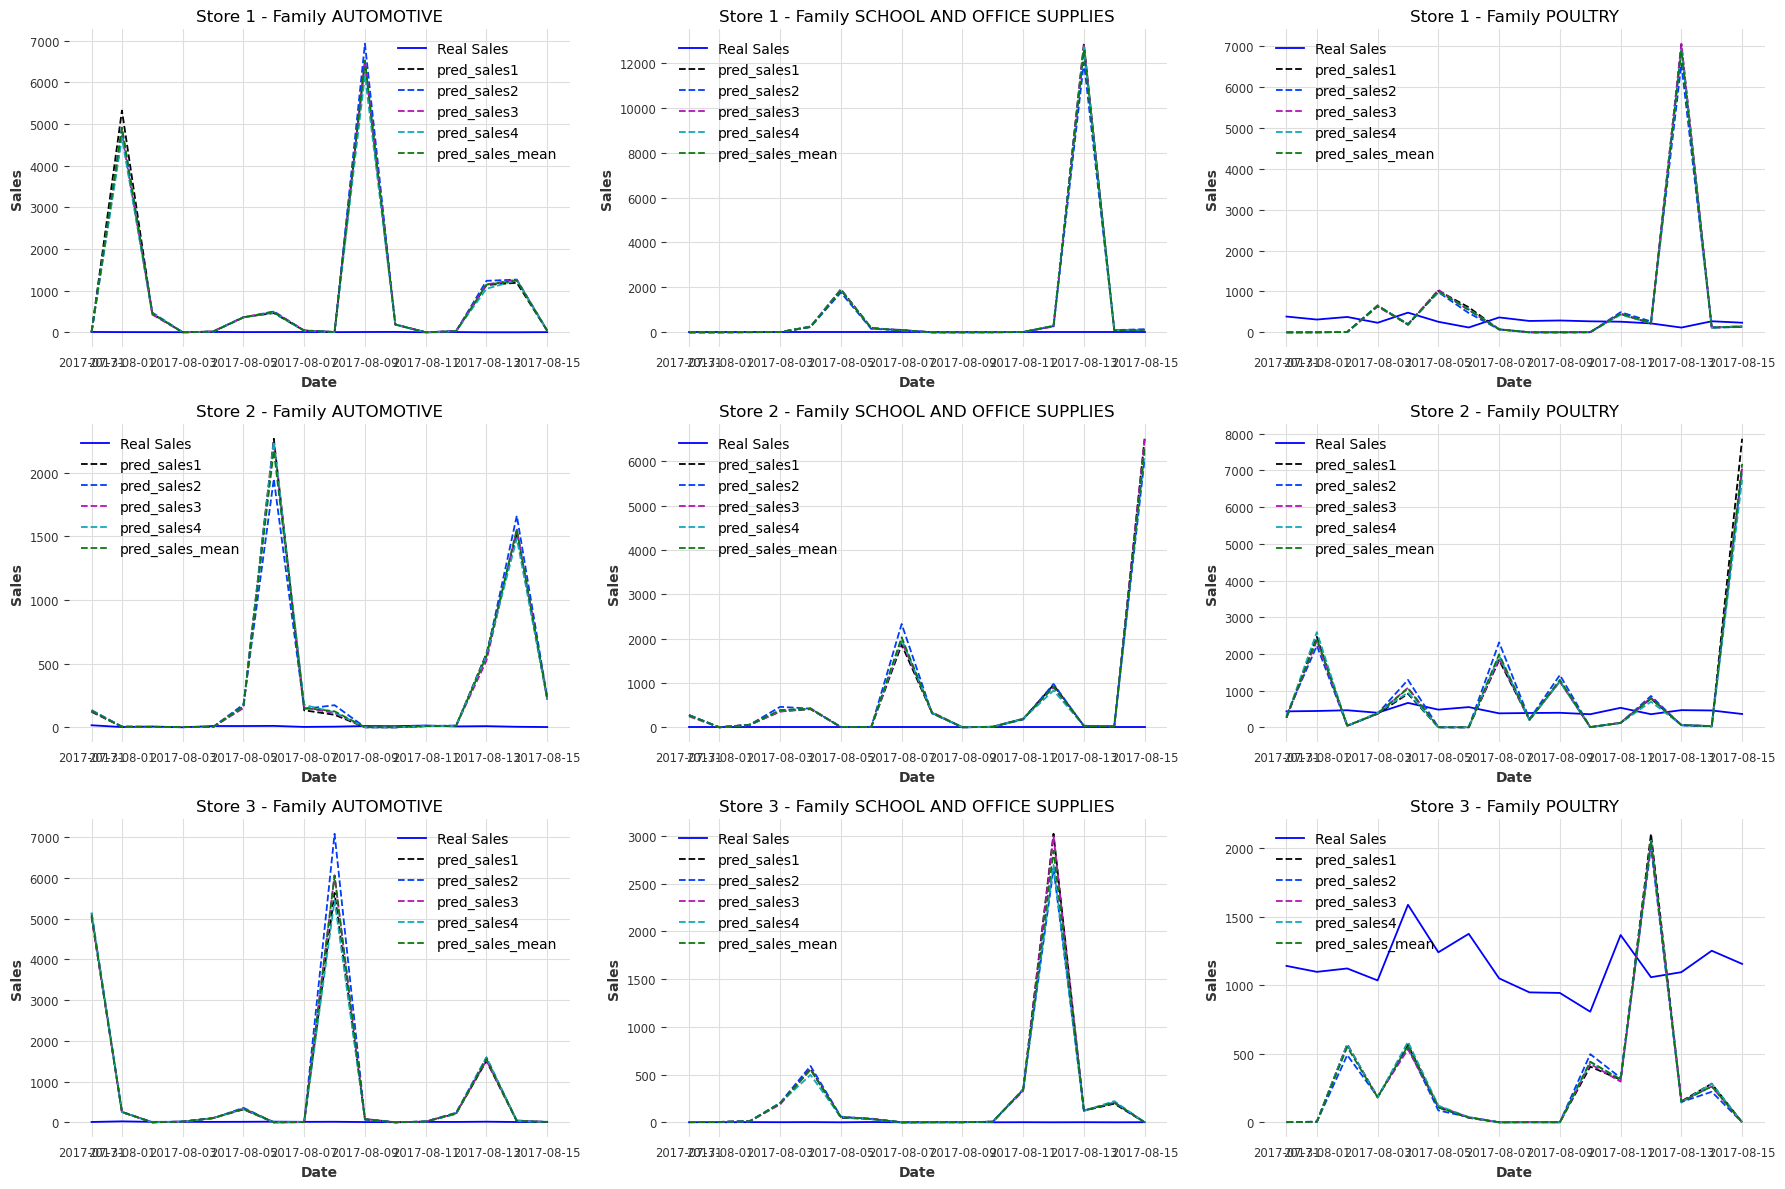

In [88]:


# Definir las tiendas y familias de interés
tiendas = [1, 2, 3]  # Por ejemplo, tienda 1, 2 y 3
familias = ['AUTOMOTIVE', 'SCHOOL AND OFFICE SUPPLIES', 'POULTRY']  # Por ejemplo, familia A, B y C

# Filtrar el DataFrame para las tiendas y familias seleccionadas
filtered_df = combined_forecasts_df_sorted[combined_forecasts_df_sorted['store_nbr'].isin(tiendas) &
                                           combined_forecasts_df_sorted['family'].isin(familias)]

# Configuración de la figura para mostrar 3x3 subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

# Recorrer las tiendas y familias para crear gráficos
for i, store in enumerate(tiendas):
    for j, family in enumerate(familias):
        ax = axes[i, j]
        
        # Filtrar los datos para la tienda y familia actual
        store_family_df = filtered_df[(filtered_df['store_nbr'] == store) & (filtered_df['family'] == family)]
        
        # Graficar ventas reales
        ax.plot(store_family_df['date'], store_family_df['sales'], label='Real Sales', color='blue')
        
        # Graficar predicciones
        for col in [col for col in store_family_df.columns if col.startswith('pred_sales')]:
            ax.plot(store_family_df['date'], store_family_df[col], label=col, linestyle='--')
        
        # Configuración del gráfico
        ax.set_title(f'Store {store} - Family {family}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend()

plt.tight_layout()
plt.show()


## Final Model

In [94]:
model_params = [
     {"lags" : 63, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 7, "lags_future_covariates" : (16,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 32, "lags_future_covariates" : (16,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 365, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 730, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]}
]

In [95]:
cutoff_date = pd.Timestamp("2015-01-01")
# Diccionario para almacenar todos los modelos entrenados con sus respectivas configuraciones
LGBM_Models_Submission = {}

for params in model_params:
    # Crear una clave única para cada configuración de parámetros
    param_key = f"lags_{params['lags']}_lagsfc_{params['lags_future_covariates'][0]}_lagspc_{'_'.join(map(str, params['lags_past_covariates']))}"
    
    display(f"Training for {param_key}...")

    LGBM_Model_Submission = {}

    for fam in tqdm(families):
        # Define Data for family
        sales_family = sales_fam_ts[fam]
        #training_data = [ts for ts in sales_family]
        training_data = [ts.drop_before(cutoff_date) for ts in sales_family]
        future_covariates = future_covariates_fam[fam]
        future_covariates = [ts.drop_before(cutoff_date) for ts in future_covariates]
        train_sliced = [training_data[i].slice_intersect(future_covariates[i]) for i in range(len(training_data))]
        transactions_ts_list_filtered = []
        for ts in transactions_ts_list:
            if ts.start_time() <= cutoff_date <= ts.end_time():
                transactions_ts_list_filtered.append(ts.drop_before(cutoff_date))
            else:
                transactions_ts_list_filtered.append(ts) 
        # Configuración del modelo
        model = LightGBMModel(
            lags=params["lags"],
            lags_future_covariates=params["lags_future_covariates"],
            lags_past_covariates=params["lags_past_covariates"],
            output_chunk_length=1,
            random_state=2022,
            gpu_use_dp="true",
            device='gpu'
        )
      
        # Entrenar el modelo
        model.fit(
            series=train_sliced, 
            future_covariates=future_covariates,
            past_covariates=transactions_ts_list_filtered
        )

        # Guardar el modelo entrenado en el diccionario específico de la familia
        LGBM_Model_Submission[fam] = model
    
    # Guardar todos los modelos entrenados para esta configuración de parámetros
    LGBM_Models_Submission[param_key] = LGBM_Model_Submission

'Training for lags_63_lagsfc_14_lagspc_-16_-17_-18_-19_-20_-21_-22...'

  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 53983
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (11.05 MB) transferred to GPU in 0.013389 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.508717


  3%|▎         | 1/33 [00:01<01:02,  1.95s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31788
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (8.29 MB) transferred to GPU in 0.011579 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.045840


  6%|▌         | 2/33 [00:03<00:48,  1.55s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 53984
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 277 dense feature groups (12.89 MB) transferred to GPU in 0.012624 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.410288


  9%|▉         | 3/33 [00:04<00:47,  1.58s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58143
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.012857 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.837279


 12%|█▏        | 4/33 [00:06<00:47,  1.63s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31944
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 454
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (8.29 MB) transferred to GPU in 0.011363 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.026860


 15%|█▌        | 5/33 [00:07<00:41,  1.47s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58128
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.013916 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.824841


 18%|█▊        | 6/33 [00:09<00:42,  1.56s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54843
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 255 dense feature groups (11.79 MB) transferred to GPU in 0.013299 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.462838


 21%|██        | 7/33 [00:11<00:41,  1.58s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58143
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.012657 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.816951


 24%|██▍       | 8/33 [00:12<00:40,  1.61s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58143
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.012759 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.847301


 27%|██▋       | 9/33 [00:14<00:39,  1.64s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58128
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.012555 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.832211


 30%|███       | 10/33 [00:16<00:38,  1.66s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57017
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.012793 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.764208


 33%|███▎      | 11/33 [00:17<00:36,  1.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57337
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.012868 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.564901


 36%|███▋      | 12/33 [00:19<00:35,  1.68s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58143
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.013467 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.825307


 39%|███▉      | 13/33 [00:21<00:33,  1.68s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50519
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 270 dense feature groups (12.52 MB) transferred to GPU in 0.012736 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.499537


 42%|████▏     | 14/33 [00:23<00:34,  1.80s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 37748
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (11.05 MB) transferred to GPU in 0.012732 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.234194


 45%|████▌     | 15/33 [00:25<00:32,  1.78s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57228
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (13.26 MB) transferred to GPU in 0.013069 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.527162


 48%|████▊     | 16/33 [00:26<00:30,  1.79s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55235
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (13.26 MB) transferred to GPU in 0.014592 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.545732


 52%|█████▏    | 17/33 [00:28<00:29,  1.82s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 30906
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (8.29 MB) transferred to GPU in 0.013041 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.117675


 55%|█████▍    | 18/33 [00:30<00:25,  1.70s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57701
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.013310 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.743348


 58%|█████▊    | 19/33 [00:31<00:24,  1.72s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 51057
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (11.05 MB) transferred to GPU in 0.012989 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.369519


 61%|██████    | 20/33 [00:33<00:21,  1.68s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 51717
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 286 dense feature groups (13.26 MB) transferred to GPU in 0.013302 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.258005


 64%|██████▎   | 21/33 [00:35<00:20,  1.70s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 52633
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (11.05 MB) transferred to GPU in 0.013253 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.390647


 67%|██████▋   | 22/33 [00:36<00:18,  1.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55563
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (13.26 MB) transferred to GPU in 0.013506 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.539903


 70%|██████▉   | 23/33 [00:38<00:17,  1.72s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 44700
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (11.05 MB) transferred to GPU in 0.013492 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.382218


 73%|███████▎  | 24/33 [00:40<00:15,  1.71s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57510
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (13.26 MB) transferred to GPU in 0.013544 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.796393


 76%|███████▌  | 25/33 [00:42<00:13,  1.74s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58053
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.014263 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.766480


 79%|███████▉  | 26/33 [00:44<00:12,  1.76s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50520
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (11.05 MB) transferred to GPU in 0.013740 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.405736


 82%|████████▏ | 27/33 [00:45<00:10,  1.72s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 51176
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 240 dense feature groups (11.05 MB) transferred to GPU in 0.013314 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.470463


 85%|████████▍ | 28/33 [00:47<00:08,  1.68s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 57828
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (13.26 MB) transferred to GPU in 0.013699 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.774549


 88%|████████▊ | 29/33 [00:49<00:06,  1.72s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54576
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (13.26 MB) transferred to GPU in 0.014053 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.779412


 91%|█████████ | 30/33 [00:50<00:05,  1.72s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 58143
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (13.81 MB) transferred to GPU in 0.014812 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.783151


 94%|█████████▍| 31/33 [00:52<00:03,  1.76s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54802
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 201 dense feature groups (9.39 MB) transferred to GPU in 0.013739 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.136781


 97%|█████████▋| 32/33 [00:54<00:01,  1.71s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 53568
[LightGBM] [Info] Number of data points in the train set: 48276, number of used features: 514
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 285 dense feature groups (13.26 MB) transferred to GPU in 0.013924 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.553654


100%|██████████| 33/33 [00:56<00:00,  1.70s/it]


'Training for lags_7_lagsfc_16_lagspc_-16_-17_-18_-19_-20_-21_-22...'

  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 44484
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 207 dense feature groups (10.02 MB) transferred to GPU in 0.014425 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.505965


  3%|▎         | 1/33 [00:01<00:49,  1.55s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31250
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (9.63 MB) transferred to GPU in 0.013298 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.043830


  6%|▌         | 2/33 [00:02<00:44,  1.45s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 44569
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 243 dense feature groups (11.75 MB) transferred to GPU in 0.013571 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.405194


  9%|▉         | 3/33 [00:04<00:46,  1.54s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49205
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.015164 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.831579


 12%|█▏        | 4/33 [00:06<00:46,  1.60s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 30654
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 434
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (9.63 MB) transferred to GPU in 0.014848 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.025682


 15%|█▌        | 5/33 [00:07<00:42,  1.53s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49187
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.015462 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.822383


 18%|█▊        | 6/33 [00:09<00:43,  1.61s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 45465
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 224 dense feature groups (10.79 MB) transferred to GPU in 0.014038 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.442542


 21%|██        | 7/33 [00:11<00:42,  1.65s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49205
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.015219 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.814687


 24%|██▍       | 8/33 [00:12<00:41,  1.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49205
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.014188 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.843965


 27%|██▋       | 9/33 [00:14<00:40,  1.69s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49188
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.015055 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.830069


 30%|███       | 10/33 [00:16<00:39,  1.72s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 47887
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.014084 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.762757


 33%|███▎      | 11/33 [00:18<00:38,  1.74s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48263
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.013918 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.562555


 36%|███▋      | 12/33 [00:19<00:36,  1.74s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49205
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 274 dense feature groups (13.29 MB) transferred to GPU in 0.014067 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.822313


 39%|███▉      | 13/33 [00:21<00:34,  1.71s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 40561
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 241 dense feature groups (11.75 MB) transferred to GPU in 0.014382 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.497978


 42%|████▏     | 14/33 [00:23<00:32,  1.71s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 32639
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (10.02 MB) transferred to GPU in 0.015625 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.232369


 45%|████▌     | 15/33 [00:24<00:29,  1.65s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48168
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 258 dense feature groups (12.52 MB) transferred to GPU in 0.013780 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.523728


 48%|████▊     | 16/33 [00:26<00:28,  1.69s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 45908
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 257 dense feature groups (12.52 MB) transferred to GPU in 0.013751 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.541980


 52%|█████▏    | 17/33 [00:28<00:27,  1.71s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31152
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (9.63 MB) transferred to GPU in 0.013270 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.120090


 55%|█████▍    | 18/33 [00:29<00:24,  1.64s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48703
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.014764 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.710752


 58%|█████▊    | 19/33 [00:31<00:23,  1.68s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 40981
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (10.02 MB) transferred to GPU in 0.013640 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.353316


 61%|██████    | 20/33 [00:33<00:21,  1.64s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 41919
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 258 dense feature groups (12.52 MB) transferred to GPU in 0.014035 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.255822


 64%|██████▎   | 21/33 [00:35<00:21,  1.76s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 42924
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (10.02 MB) transferred to GPU in 0.014197 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.389986


 67%|██████▋   | 22/33 [00:36<00:18,  1.69s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 46281
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 258 dense feature groups (12.52 MB) transferred to GPU in 0.014044 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.536562


 70%|██████▉   | 23/33 [00:38<00:17,  1.71s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 34034
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (10.02 MB) transferred to GPU in 0.013164 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.365458


 73%|███████▎  | 24/33 [00:39<00:14,  1.64s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48556
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 258 dense feature groups (12.52 MB) transferred to GPU in 0.013841 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.793958


 76%|███████▌  | 25/33 [00:41<00:13,  1.66s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49103
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.014669 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.764144


 79%|███████▉  | 26/33 [00:43<00:11,  1.68s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 40630
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 206 dense feature groups (10.02 MB) transferred to GPU in 0.014089 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.387944


 82%|████████▏ | 27/33 [00:44<00:09,  1.66s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 41304
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 207 dense feature groups (10.02 MB) transferred to GPU in 0.014516 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.449833


 85%|████████▍ | 28/33 [00:46<00:08,  1.62s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48874
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 258 dense feature groups (12.52 MB) transferred to GPU in 0.013886 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.772375


 88%|████████▊ | 29/33 [00:48<00:06,  1.64s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 45159
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 258 dense feature groups (12.52 MB) transferred to GPU in 0.013752 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.776233


 91%|█████████ | 30/33 [00:49<00:05,  1.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49205
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 275 dense feature groups (13.29 MB) transferred to GPU in 0.015620 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.752958


 94%|█████████▍| 31/33 [00:51<00:03,  1.70s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 45480
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (9.63 MB) transferred to GPU in 0.013311 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.130783


 97%|█████████▋| 32/33 [00:53<00:01,  1.64s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 44020
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 502
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 258 dense feature groups (12.52 MB) transferred to GPU in 0.014011 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.551559


100%|██████████| 33/33 [00:54<00:00,  1.66s/it]


'Training for lags_32_lagsfc_16_lagspc_-16_-17_-18_-19_-20_-21_-22...'

  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50867
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 232 dense feature groups (11.05 MB) transferred to GPU in 0.013448 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.506581


  3%|▎         | 1/33 [00:01<00:51,  1.62s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 33000
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (9.53 MB) transferred to GPU in 0.013196 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.044303


  6%|▌         | 2/33 [00:03<00:46,  1.50s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50919
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 271 dense feature groups (12.96 MB) transferred to GPU in 0.014107 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.406449


  9%|▉         | 3/33 [00:04<00:49,  1.66s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55580
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 299 dense feature groups (14.29 MB) transferred to GPU in 0.014293 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.832986


 12%|█▏        | 4/33 [00:06<00:50,  1.75s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 32704
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 459
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (9.53 MB) transferred to GPU in 0.013251 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.025960


 15%|█▌        | 5/33 [00:08<00:45,  1.61s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55563
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 299 dense feature groups (14.29 MB) transferred to GPU in 0.014483 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.822948


 18%|█▊        | 6/33 [00:10<00:46,  1.72s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 51840
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 249 dense feature groups (12.00 MB) transferred to GPU in 0.014220 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.447326


 21%|██        | 7/33 [00:11<00:45,  1.74s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55580
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (14.29 MB) transferred to GPU in 0.016424 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.815274


 24%|██▍       | 8/33 [00:13<00:44,  1.79s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55580
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 299 dense feature groups (14.29 MB) transferred to GPU in 0.014224 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.844747


 27%|██▋       | 9/33 [00:15<00:43,  1.80s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55563
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (14.29 MB) transferred to GPU in 0.014317 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.830590


 30%|███       | 10/33 [00:17<00:41,  1.80s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54267
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (14.29 MB) transferred to GPU in 0.014307 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.763065


 33%|███▎      | 11/33 [00:19<00:40,  1.83s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54649
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (14.29 MB) transferred to GPU in 0.014722 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.563161


 36%|███▋      | 12/33 [00:21<00:38,  1.83s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55580
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 299 dense feature groups (14.29 MB) transferred to GPU in 0.014173 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.823071


 39%|███▉      | 13/33 [00:22<00:35,  1.80s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 46937
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 266 dense feature groups (12.77 MB) transferred to GPU in 0.013630 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.498372


 42%|████▏     | 14/33 [00:24<00:34,  1.80s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 36489
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 231 dense feature groups (11.05 MB) transferred to GPU in 0.014821 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.233091


 45%|████▌     | 15/33 [00:26<00:31,  1.73s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54543
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 283 dense feature groups (13.53 MB) transferred to GPU in 0.014164 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.524527


 48%|████▊     | 16/33 [00:28<00:29,  1.76s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 52283
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 282 dense feature groups (13.53 MB) transferred to GPU in 0.013924 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.542980


 52%|█████▏    | 17/33 [00:29<00:28,  1.78s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 32552
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 199 dense feature groups (9.53 MB) transferred to GPU in 0.013140 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.119545


 55%|█████▍    | 18/33 [00:31<00:25,  1.69s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55078
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 299 dense feature groups (14.29 MB) transferred to GPU in 0.014415 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.718435


 58%|█████▊    | 19/33 [00:33<00:24,  1.74s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 47353
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 231 dense feature groups (11.05 MB) transferred to GPU in 0.013347 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.357135


 61%|██████    | 20/33 [00:34<00:21,  1.69s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 48296
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 283 dense feature groups (13.53 MB) transferred to GPU in 0.013333 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.256480


 64%|██████▎   | 21/33 [00:36<00:20,  1.70s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 49299
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 231 dense feature groups (11.05 MB) transferred to GPU in 0.013204 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.390215


 67%|██████▋   | 22/33 [00:38<00:18,  1.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 52656
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 282 dense feature groups (13.53 MB) transferred to GPU in 0.015321 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.537853


 70%|██████▉   | 23/33 [00:39<00:17,  1.71s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 40384
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 231 dense feature groups (11.05 MB) transferred to GPU in 0.013320 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.369409


 73%|███████▎  | 24/33 [00:41<00:15,  1.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 54913
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 282 dense feature groups (13.53 MB) transferred to GPU in 0.013778 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.794594


 76%|███████▌  | 25/33 [00:43<00:13,  1.70s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55478
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (14.29 MB) transferred to GPU in 0.014281 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.764658


 79%|███████▉  | 26/33 [00:45<00:12,  1.73s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 46980
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 232 dense feature groups (11.05 MB) transferred to GPU in 0.012925 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.392138


 82%|████████▏ | 27/33 [00:46<00:10,  1.70s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 47679
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 232 dense feature groups (11.05 MB) transferred to GPU in 0.015029 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.454696


 85%|████████▍ | 28/33 [00:48<00:08,  1.67s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55244
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 282 dense feature groups (13.53 MB) transferred to GPU in 0.014795 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.772864


 88%|████████▊ | 29/33 [00:50<00:07,  1.81s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 51534
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 283 dense feature groups (13.53 MB) transferred to GPU in 0.013373 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.776971


 91%|█████████ | 30/33 [00:52<00:05,  1.79s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 55580
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 300 dense feature groups (14.29 MB) transferred to GPU in 0.013858 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.760105


 94%|█████████▍| 31/33 [00:53<00:03,  1.79s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 51830
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 200 dense feature groups (9.53 MB) transferred to GPU in 0.013710 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.132197


 97%|█████████▋| 32/33 [00:55<00:01,  1.71s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50395
[LightGBM] [Info] Number of data points in the train set: 49950, number of used features: 527
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 282 dense feature groups (13.53 MB) transferred to GPU in 0.014120 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.552186


100%|██████████| 33/33 [00:57<00:00,  1.73s/it]


'Training for lags_365_lagsfc_14_lagspc_-16_-17_-18_-19_-20_-21_-22...'

  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 131052
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (16.58 MB) transferred to GPU in 0.014610 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.522057


  3%|▎         | 1/33 [00:02<01:11,  2.23s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 51562
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 176 dense feature groups (5.37 MB) transferred to GPU in 0.011660 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.061506


  6%|▌         | 2/33 [00:03<00:53,  1.73s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 130623
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 586 dense feature groups (17.93 MB) transferred to GPU in 0.016087 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.438416


  9%|▉         | 3/33 [00:06<01:00,  2.03s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135151
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015454 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.856404


 12%|█▏        | 4/33 [00:08<01:04,  2.24s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50945
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 698
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (5.49 MB) transferred to GPU in 0.011306 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.040562


 15%|█▌        | 5/33 [00:09<00:53,  1.89s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135127
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.016378 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.835288


 18%|█▊        | 6/33 [00:12<00:56,  2.08s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 131843
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 557 dense feature groups (17.07 MB) transferred to GPU in 0.014913 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.509892


 21%|██        | 7/33 [00:14<00:56,  2.16s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135151
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015365 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.827355


 24%|██▍       | 8/33 [00:17<00:56,  2.26s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135151
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.014812 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.864551


 27%|██▋       | 9/33 [00:19<00:55,  2.31s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135136
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015387 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.840876


 30%|███       | 10/33 [00:22<00:54,  2.37s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134437
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015545 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.773826


 33%|███▎      | 11/33 [00:24<00:52,  2.37s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134310
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015507 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.570554


 36%|███▋      | 12/33 [00:26<00:50,  2.41s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135151
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.014956 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.838853


 39%|███▉      | 13/33 [00:29<00:48,  2.44s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 127451
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (17.93 MB) transferred to GPU in 0.015791 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.500530


 42%|████▏     | 14/33 [00:31<00:45,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 80276
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (16.58 MB) transferred to GPU in 0.015565 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.241461


 45%|████▌     | 15/33 [00:33<00:41,  2.32s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134236
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015289 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.539994


 48%|████▊     | 16/33 [00:36<00:39,  2.34s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 132218
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.016706 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.557954


 52%|█████▏    | 17/33 [00:38<00:37,  2.34s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 46627
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 177 dense feature groups (5.49 MB) transferred to GPU in 0.011715 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.118178


 55%|█████▍    | 18/33 [00:40<00:31,  2.10s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134735
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015935 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.804034


 58%|█████▊    | 19/33 [00:42<00:30,  2.19s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 127357
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 540 dense feature groups (16.46 MB) transferred to GPU in 0.014945 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.408757


 61%|██████    | 20/33 [00:44<00:28,  2.20s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 128692
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (17.93 MB) transferred to GPU in 0.016894 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.283450


 64%|██████▎   | 21/33 [00:47<00:26,  2.23s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 129613
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (16.58 MB) transferred to GPU in 0.014441 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.380202


 67%|██████▋   | 22/33 [00:49<00:24,  2.25s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 132530
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015010 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.561533


 70%|██████▉   | 23/33 [00:51<00:22,  2.29s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 121406
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (16.58 MB) transferred to GPU in 0.015796 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.454330


 73%|███████▎  | 24/33 [00:53<00:20,  2.28s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134518
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (17.93 MB) transferred to GPU in 0.014745 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.805996


 76%|███████▌  | 25/33 [00:56<00:18,  2.33s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135029
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015317 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.777926


 79%|███████▉  | 26/33 [00:58<00:16,  2.34s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 127214
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 557 dense feature groups (17.07 MB) transferred to GPU in 0.015388 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.477798


 82%|████████▏ | 27/33 [01:01<00:13,  2.33s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 128104
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 542 dense feature groups (16.58 MB) transferred to GPU in 0.014881 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.530181


 85%|████████▍ | 28/33 [01:03<00:11,  2.29s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 134733
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (17.93 MB) transferred to GPU in 0.016611 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.782371


 88%|████████▊ | 29/33 [01:05<00:09,  2.37s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 131692
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (17.93 MB) transferred to GPU in 0.015138 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.790204


 91%|█████████ | 30/33 [01:08<00:07,  2.39s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 135151
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 602 dense feature groups (18.41 MB) transferred to GPU in 0.015558 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.864209


 94%|█████████▍| 31/33 [01:10<00:04,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 131735
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 452 dense feature groups (13.78 MB) transferred to GPU in 0.014533 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.163168


 97%|█████████▋| 32/33 [01:12<00:02,  2.32s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 130529
[LightGBM] [Info] Number of data points in the train set: 31968, number of used features: 816
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 587 dense feature groups (17.93 MB) transferred to GPU in 0.014860 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.563202


100%|██████████| 33/33 [01:15<00:00,  2.28s/it]


'Training for lags_730_lagsfc_14_lagspc_-16_-17_-18_-19_-20_-21_-22...'

  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 220561
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 907 dense feature groups (10.61 MB) transferred to GPU in 0.016600 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.538728


  3%|▎         | 1/33 [00:02<01:17,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 59700
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1131
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 161 dense feature groups (1.92 MB) transferred to GPU in 0.011050 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.058536


  6%|▌         | 2/33 [00:03<00:54,  1.76s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 219370
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 950 dense feature groups (11.13 MB) transferred to GPU in 0.016644 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.461943


  9%|▉         | 3/33 [00:06<01:04,  2.16s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 225060
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 953 dense feature groups (11.18 MB) transferred to GPU in 0.015381 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.872324


 12%|█▏        | 4/33 [00:08<01:06,  2.31s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 46364
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 663
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 161 dense feature groups (1.92 MB) transferred to GPU in 0.011343 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.044703


 15%|█▌        | 5/33 [00:09<00:52,  1.87s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 225033
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 952 dense feature groups (11.13 MB) transferred to GPU in 0.015293 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.846985


 18%|█▊        | 6/33 [00:12<01:00,  2.24s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 219456
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 896 dense feature groups (10.47 MB) transferred to GPU in 0.014559 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.514540


 21%|██        | 7/33 [00:15<00:59,  2.27s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 225056
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 953 dense feature groups (11.18 MB) transferred to GPU in 0.015849 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.839706


 24%|██▍       | 8/33 [00:17<00:59,  2.36s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 225060
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 953 dense feature groups (11.18 MB) transferred to GPU in 0.014906 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.879173


 27%|██▋       | 9/33 [00:20<00:57,  2.41s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 225048
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 953 dense feature groups (11.18 MB) transferred to GPU in 0.016892 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.854190


 30%|███       | 10/33 [00:23<00:57,  2.49s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 223648
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 953 dense feature groups (11.18 MB) transferred to GPU in 0.015683 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.786209


 33%|███▎      | 11/33 [00:25<00:55,  2.51s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 224291
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 952 dense feature groups (11.13 MB) transferred to GPU in 0.016932 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.571581


 36%|███▋      | 12/33 [00:28<00:54,  2.62s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 225060
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 953 dense feature groups (11.18 MB) transferred to GPU in 0.016312 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.850491


 39%|███▉      | 13/33 [00:30<00:51,  2.58s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 216335
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 937 dense feature groups (10.99 MB) transferred to GPU in 0.017905 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.533426


 42%|████▏     | 14/33 [00:33<00:48,  2.55s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 110877
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1138
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 891 dense feature groups (10.43 MB) transferred to GPU in 0.015379 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.257642


 45%|████▌     | 15/33 [00:35<00:43,  2.40s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 223990
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 952 dense feature groups (11.13 MB) transferred to GPU in 0.016285 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.563459


 48%|████▊     | 16/33 [00:38<00:42,  2.50s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 222053
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 952 dense feature groups (11.13 MB) transferred to GPU in 0.016540 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.586823


 52%|█████▏    | 17/33 [00:40<00:39,  2.49s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 56966
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 161 dense feature groups (1.92 MB) transferred to GPU in 0.010754 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.161782


 55%|█████▍    | 18/33 [00:42<00:32,  2.18s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 224560
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 953 dense feature groups (11.18 MB) transferred to GPU in 0.017307 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.815410


 58%|█████▊    | 19/33 [00:44<00:32,  2.31s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 214178
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 832 dense feature groups (9.73 MB) transferred to GPU in 0.014591 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.421150


 61%|██████    | 20/33 [00:46<00:29,  2.28s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 218408
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 937 dense feature groups (10.99 MB) transferred to GPU in 0.015918 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.368888


 64%|██████▎   | 21/33 [00:49<00:27,  2.30s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 218557
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 891 dense feature groups (10.43 MB) transferred to GPU in 0.015085 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.418700


 67%|██████▋   | 22/33 [00:51<00:25,  2.32s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 222173
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 951 dense feature groups (11.13 MB) transferred to GPU in 0.014731 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.576151


 70%|██████▉   | 23/33 [00:54<00:23,  2.39s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 209655
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1131
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 838 dense feature groups (9.82 MB) transferred to GPU in 0.015343 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.464328


 73%|███████▎  | 24/33 [00:56<00:21,  2.34s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 224517
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 938 dense feature groups (10.99 MB) transferred to GPU in 0.015067 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.818149


 76%|███████▌  | 25/33 [00:58<00:19,  2.38s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 224830
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 953 dense feature groups (11.18 MB) transferred to GPU in 0.016837 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.787317


 79%|███████▉  | 26/33 [01:01<00:16,  2.43s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 215978
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 849 dense feature groups (9.96 MB) transferred to GPU in 0.014752 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.546533


 82%|████████▏ | 27/33 [01:03<00:14,  2.38s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 215617
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 870 dense feature groups (10.19 MB) transferred to GPU in 0.014131 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.558631


 85%|████████▍ | 28/33 [01:05<00:11,  2.34s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 224233
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 937 dense feature groups (10.99 MB) transferred to GPU in 0.014668 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.790974


 88%|████████▊ | 29/33 [01:08<00:09,  2.41s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 221526
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 952 dense feature groups (11.13 MB) transferred to GPU in 0.016835 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.792289


 91%|█████████ | 30/33 [01:10<00:07,  2.41s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 225060
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 953 dense feature groups (11.18 MB) transferred to GPU in 0.015627 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.877601


 94%|█████████▍| 31/33 [01:13<00:04,  2.42s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 221206
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 732 dense feature groups (8.56 MB) transferred to GPU in 0.014355 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.182329


 97%|█████████▋| 32/33 [01:15<00:02,  2.30s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 219265
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 1146
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 16
[LightGBM] [Info] 935 dense feature groups (10.94 MB) transferred to GPU in 0.015790 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.567342


100%|██████████| 33/33 [01:17<00:00,  2.36s/it]


In [96]:
# Diccionario para almacenar todas las predicciones para cada configuración de parámetros
all_predictions_dict = {}

# Iterar sobre cada configuración de parámetros
for idx, params in enumerate(model_params):
    # Crear una clave única para cada configuración de parámetros
    param_key = f"lags_{params['lags']}_lagsfc_{params['lags_future_covariates'][0]}_lagspc_{'_'.join(map(str, params['lags_past_covariates']))}"
    
    LGBM_Forecasts_Families_back_Submission = {}
    
    for fam in tqdm(families):
        # Define Data for family
        sales_family = sales_fam_ts[fam]
        training_data = [ts for ts in sales_family] 
        future_covariates = future_covariates_fam[fam]
        train_sliced = [training_data[i].slice_intersect(future_covariates[i]) for i in range(len(training_data))]

        # Obtener el modelo correspondiente a la configuración actual
        model = LGBM_Models_Submission[param_key][fam]
        
        # Realizar la predicción
        forecast_LGBM = model.predict(
            n=16,
            series=train_sliced,
            future_covariates=future_covariates,
            past_covariates=transactions_ts_list
        )
        
        LGBM_Forecasts_Families_back_Submission[fam] = forecast_LGBM
    
    # Aplicar la inversa de la transformación para las predicciones
    for family in tqdm(families):
        LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(
            LGBM_Forecasts_Families_back_Submission[family], partial=True
        )

    # Ajuste de predicciones para series con valores cero
    for family in tqdm(LGBM_Forecasts_Families_back_Submission):
        for n in range(len(LGBM_Forecasts_Families_back_Submission[family])):
            if (sales_fam_ts[family][n].univariate_values()[-21:] == 0).all():
                LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)

    listofseries = []

    # Generación del DataFrame de pronósticos para esta configuración de parámetros
    for store in tqdm(range(0, 54)):
        for family in families:
            oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
            oneforecast.columns = [f'pred_sales{idx+1}']  # Asignar un nombre único a cada columna de predicción
            listofseries.append(oneforecast)
        
    df_forecasts = pd.concat(listofseries) 
    df_forecasts.reset_index(drop=True, inplace=True)
    
    # No Negative Forecasts
    df_forecasts[df_forecasts < 0] = 0

    # Guardar las predicciones en un diccionario
    all_predictions_dict[f'pred_sales{idx+1}'] = df_forecasts.set_index(test_submit.index)

# Combinar todas las predicciones en un único DataFrame
combined_forecasts_df = test_submit.copy()
for key in all_predictions_dict:
    combined_forecasts_df[key] = all_predictions_dict[key]

# Calcular la media de todas las predicciones y añadirla como una nueva columna
combined_forecasts_df['pred_sales_mean'] = combined_forecasts_df[[f'pred_sales{idx+1}' for idx in range(len(model_params))]].mean(axis=1)

# Ordenar el DataFrame final
combined_forecasts_df_sorted = combined_forecasts_df.sort_values(by=['id']).reset_index(drop=True)



100%|██████████| 54/54 [00:00<00:00, 224.71it/s]


In [97]:
combined_forecasts_df_sorted.head()

,id,date,store_nbr,family,onpromotion,pred_sales1,pred_sales2,pred_sales3,pred_sales4,pred_sales5,pred_sales_mean
0,3000888,2017-08-16,1,AUTOMOTIVE,0,3.269966,2.941656,3.172872,2.923646,2.597953,2.981219
1,3000889,2017-08-16,1,BABY CARE,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3000890,2017-08-16,1,BEAUTY,2,3.984951,4.271767,4.254381,4.011480,4.711392,4.246794
3,3000891,2017-08-16,1,BEVERAGES,20,2306.645078,2147.459613,2272.274031,2328.074244,2297.783820,2270.447357
4,3000892,2017-08-16,1,BOOKS,0,0.023751,0.044163,0.049734,0.018919,0.050380,0.037389


In [98]:
df_sample_submission = pd.read_csv('sample_submission.csv')
display(df_sample_submission.head())

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [99]:
df_sample_submission['sales'] = combined_forecasts_df_sorted["pred_sales_mean"]

In [100]:
df_sample_submission.head()

,id,sales
0,3000888,2.981219
1,3000889,0.000000
2,3000890,4.246794
3,3000891,2270.447357
4,3000892,0.037389


In [101]:
df_sample_submission.to_csv('submission24.csv', index=False)